# Set-Up

In [351]:
# Block 1: Install requirements 

!pip install -r requirements.txt

In [352]:
# Block 2: Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [353]:
# Block 3: Suppress warnings

warnings.filterwarnings('ignore')

In [354]:
# Block 4: Import Data

ids = pd.read_csv('/Users/tessacannon/Documents/UCL/Applied AI/dataset_diabetes/IDs_mapping.csv',header=None, names=["id", "description"])
full_data = pd.read_csv('/Users/tessacannon/Documents/UCL/Applied AI/dataset_diabetes/diabetic_data.csv')

In [355]:
# Block 5: Take a sample of the data

data = full_data.sample(frac=0.50, random_state=24112897).reset_index(drop=True)

# Data Cleaning and Preparation

In [356]:
# Block 6: Examine ID data

ids

id                                        description
0   admission_type_id                                        description
1                   1                                          Emergency
2                   2                                             Urgent
3                   3                                           Elective
4                   4                                            Newborn
..                ...                                                ...
63                 22   Transfer from hospital inpt/same fac reslt in...
64                 23                          Born inside this hospital
65                 24                         Born outside this hospital
66                 25            Transfer from Ambulatory Surgery Center
67                 26                              Transfer from Hospice

[68 rows x 2 columns]

In [357]:
# Block 7: Examine Diabates Data

data

encounter_id  patient_nbr       race  gender      age     weight  \
0         278913204      2274813          ?  Female  [50-60)          ?   
1         130125492      4981140  Caucasian    Male  [60-70)          ?   
2          77887872      5500116  Caucasian    Male  [60-70)          ?   
3         414380618    112563099  Caucasian    Male  [80-90)          ?   
4         329018342    122428580          ?  Female  [80-90)          ?   
...             ...          ...        ...     ...      ...        ...   
50878     184199616     60102693  Caucasian    Male  [20-30)          ?   
50879     194553030     92158929  Caucasian    Male  [60-70)          ?   
50880      68357706      3353715  Caucasian    Male  [60-70)          ?   
50881     420828782     64714149  Caucasian    Male  [50-60)  [100-125)   
50882     102593604     23348376  Caucasian  Female  [70-80)          ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \
0                      1                         3                    1   
1                      1                         1                    7   
2                      1                         1                    7   
3                      3                        22                    5   
4                      1                         3                    7   
...                  ...                       ...                  ...   
50878                  1                         1                    7   
50879                  5                         6                    1   
50880                  1                         1                    7   
50881                  2                         6                    1   
50882                  3                         6                    1   

       time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                     7  ...          No      No                   No   
1                     4  ...          No    Down                   No   
2                     7  ...          No  Steady                   No   
3                     9  ...          No      Up                   No   
4                     6  ...          No  Steady                   No   
...                 ...  ...         ...     ...                  ...   
50878                 3  ...          No    Down                   No   
50879                 4  ...          No  Steady                   No   
50880                 5  ...          No      No                   No   
50881                14  ...          No  Steady                   No   
50882                 4  ...          No      No                   No   

       glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                       No                        No                       No   
1                       No                        No                       No   
2                       No                        No                       No   
3                       No                        No                       No   
4                       No                        No                       No   
...                    ...                       ...                      ...   
50878                   No                        No                       No   
50879                   No                        No                       No   
50880                   No                        No                       No   
50881                   No                        No                       No   
50882                   No                        No                       No   

       metformin-pioglitazone  change diabetesMed readmitted  
0                          No      No          No         NO  
1                          No      Ch         Yes         NO  
2                          No      No         Yes         NO  
3                          No      Ch         Yes        >30  
4                          No      Ch   

In [358]:
# Block 8: Separate stacked columns in ids csv

# Identify the header rows that indicate the start of a new section
header_indices = ids[ids["id"].str.contains("admission_type_id|discharge_disposition_id|admission_source_id", na=False)].index

# Split into three separate DataFrames
admission_type_id = ids.iloc[header_indices[0] + 1 : header_indices[1]].reset_index(drop=True).dropna(subset=['id'])
discharge_disposition_id = ids.iloc[header_indices[1] + 1 : header_indices[2]].reset_index(drop=True).dropna(subset=['id'])
admission_source_id = ids.iloc[header_indices[2] + 1 :].reset_index(drop=True).dropna(subset=['id'])

# Rename columns accordingly
admission_type_id.columns = ["admission_type_id", "admission_type_desc"]
discharge_disposition_id.columns = ["discharge_disposition_id", "discharge_disposition_desc"]
admission_source_id.columns = ["admission_source_id", "admission_source_desc"]


In [359]:
# Block 9: Merge data

# Convert ids in both dataframes to a common type
data['admission_type_id'] = data['admission_type_id'].astype(str)
admission_type_id['admission_type_id'] = admission_type_id['admission_type_id'].astype(str)
data['discharge_disposition_id'] = data['discharge_disposition_id'].astype(str)
discharge_disposition_id['discharge_disposition_id'] = discharge_disposition_id['discharge_disposition_id'].astype(str)
data['admission_source_id'] = data['admission_source_id'].astype(str)
admission_source_id['admission_source_id'] = admission_source_id['admission_source_id'].astype(str)

# Left join ids to data on id
df = data.merge(admission_type_id, on='admission_type_id', how='left')
df = df.merge(discharge_disposition_id, on='discharge_disposition_id', how='left')
df = df.merge(admission_source_id, on='admission_source_id', how='left').drop(columns=['admission_type_id','discharge_disposition_id','admission_source_id']) # Drop the ID columns after all merges are complete

df.head()

encounter_id  patient_nbr       race  gender      age weight  \
0     278913204      2274813          ?  Female  [50-60)      ?   
1     130125492      4981140  Caucasian    Male  [60-70)      ?   
2      77887872      5500116  Caucasian    Male  [60-70)      ?   
3     414380618    112563099  Caucasian    Male  [80-90)      ?   
4     329018342    122428580          ?  Female  [80-90)      ?   

   time_in_hospital payer_code medical_specialty  num_lab_procedures  ...  \
0                 7          ?        Nephrology                  54  ...   
1                 4         MC                 ?                  51  ...   
2                 7          ?        Nephrology                  56  ...   
3                 9         MC                 ?                  68  ...   
4                 6          ?                 ?                  59  ...   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted admission_type_desc  \
0                      No      No          No         NO           Emergency   
1                      No      Ch         Yes         NO           Emergency   
2                      No      No         Yes         NO           Emergency   
3                      No      Ch         Yes        >30            Elective   
4                      No      Ch         Yes         NO           Emergency   

                          discharge_disposition_desc  \
0                      Discharged/transferred to SNF   
1                                 Discharged to home   
2                                 Discharged to home   
3  Discharged/transferred to another rehab fac in...   
4                      Discharged/transferred to SNF   

                             admission_source_desc  
0                               Physician Referral  
1                                   Emergency Room  
2                                   Emergency Room  
3   Transfer from a Skilled Nursing Facility (SNF)  
4                                   Emergency Room  

[5 rows x 50 columns]

In [360]:
# Block 10: Simplify response variable into binary variable

# Reassign response variable
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if (x == '<30'or x == '>30') else 0)

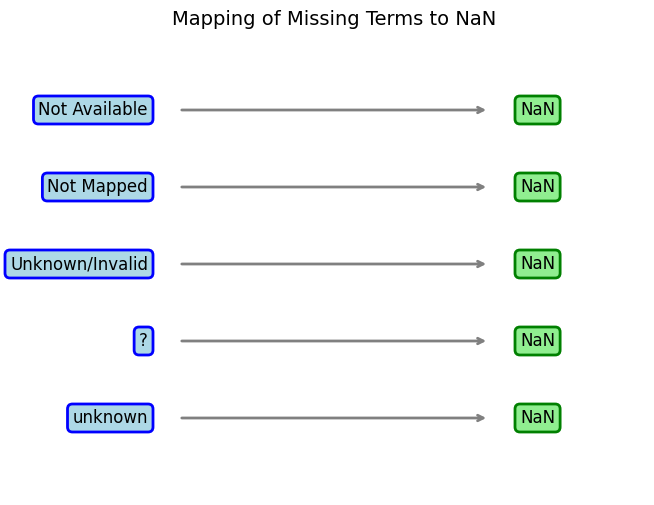

In [361]:
# Block 11: Unify nomenclature for missing data

for col in ['admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']:
    df[col] = df[col].str.strip()

missing_terms = ['Not Available','Not Mapped', 'Unknown/Invalid', '?', 'unknown']

df.replace(missing_terms, np.nan, inplace=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  # Hide axes

# Set positions for the terms and NaN text
y_positions = list(range(len(missing_terms), 0, -1))
x_left = 0.2
x_right = 0.8

# Add missing term texts and NaN text with arrows between them
for i, term in enumerate(missing_terms):
    y = y_positions[i] / (len(missing_terms)+1)
    ax.text(x_left, y, term, fontsize=12, ha='right', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="b", lw=2))
    ax.text(x_right, y, 'NaN', fontsize=12, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="g", lw=2))
    # Draw arrow
    ax.annotate("", xy=(x_right - 0.05, y), xytext=(x_left + 0.05, y),
                arrowprops=dict(arrowstyle="->", lw=2, color='gray'))

# Add title to the figure
plt.title("Mapping of Missing Terms to NaN", fontsize=14)

plt.show()


In [362]:
# Block 12: Get dataframe summary with datatypes

df.info()

# Block 13: Get summary statistics for numerical columns

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50883 entries, 0 to 50882
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   encounter_id                50883 non-null  int64 
 1   patient_nbr                 50883 non-null  int64 
 2   race                        49737 non-null  object
 3   gender                      50881 non-null  object
 4   age                         50883 non-null  object
 5   weight                      1620 non-null   object
 6   time_in_hospital            50883 non-null  int64 
 7   payer_code                  30802 non-null  object
 8   medical_specialty           25930 non-null  object
 9   num_lab_procedures          50883 non-null  int64 
 10  num_procedures              50883 non-null  int64 
 11  num_medications             50883 non-null  int64 
 12  number_outpatient           50883 non-null  int64 
 13  number_emergency            50883 non-null  in

encounter_id   patient_nbr  time_in_hospital  num_lab_procedures  \
count  5.088300e+04  5.088300e+04      50883.000000        50883.000000   
mean   1.647378e+08  5.435726e+07          4.412554           43.118743   
std    1.024167e+08  3.873423e+07          3.003161           19.757616   
min    1.252200e+04  1.350000e+02          1.000000            1.000000   
25%    8.459730e+07  2.340197e+07          2.000000           31.000000   
50%    1.520619e+08  4.568562e+07          4.000000           44.000000   
75%    2.294238e+08  8.761465e+07          6.000000           57.000000   
max    4.438672e+08  1.895026e+08         14.000000          129.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count    50883.000000     50883.000000       50883.000000      50883.000000   
mean         1.342374        16.040662           0.371774          0.195429   
std          1.704708         8.180137           1.265679          0.895251   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        75.000000          40.000000         64.000000   

       number_inpatient  number_diagnoses    readmitted  
count      50883.000000      50883.000000  50883.000000  
mean           0.626241          7.413635      0.459427  
std            1.229668          1.935566      0.498356  
min            0.000000          1.000000      0.000000  
25%            0.000000          6.000000      0.000000  
50%            0.000000          8.000000      0.000000  
75%            1.000000          9.000000      1.000000  
max           19.000000         16.000000      1.000000

In [363]:
# Block 13: Label Data Types
# Define the lists for each category
numeric_cols = [
    'encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'readmitted'
]

cat_nominal_cols = [
    'race', 'gender', 'payer_code', 'medical_specialty',
    'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed',
    'admission_type_desc', 'discharge_disposition_desc',
    'admission_source_desc'
]

cat_ordinal_cols = ['age', 'weight', 'max_glu_serum', 'A1Cresult']

# Create a dictionary mapping column names to their data type.
data_type_mapping = {}

# Assign numeric columns
for col in numeric_cols:
    data_type_mapping[col] = 'Numeric (ratio)'

# Assign ordinal columns (if a column appears in both ordinal and nominal, we'll mark it ordinal)
for col in cat_ordinal_cols:
    data_type_mapping[col] = 'Categorical (ordinal)'

# Assign nominal columns for any columns not already assigned as ordinal
for col in cat_nominal_cols:
    if col not in data_type_mapping:
        data_type_mapping[col] = 'Categorical (nominal)'

# Create a DataFrame to display the mapping
df_mapping = pd.DataFrame(list(data_type_mapping.items()), columns=['Feature', 'Data Type'])
df_mapping.sort_values('Data Type', inplace=True,ascending=False)

print(df_mapping)


                       Feature              Data Type
0                 encounter_id        Numeric (ratio)
2             time_in_hospital        Numeric (ratio)
3           num_lab_procedures        Numeric (ratio)
4               num_procedures        Numeric (ratio)
5              num_medications        Numeric (ratio)
6            number_outpatient        Numeric (ratio)
7             number_emergency        Numeric (ratio)
8             number_inpatient        Numeric (ratio)
9             number_diagnoses        Numeric (ratio)
10                  readmitted        Numeric (ratio)
1                  patient_nbr        Numeric (ratio)
13               max_glu_serum  Categorical (ordinal)
14                   A1Cresult  Categorical (ordinal)
11                         age  Categorical (ordinal)
12                      weight  Categorical (ordinal)
34                    miglitol  Categorical (nominal)
35                troglitazone  Categorical (nominal)
36                  tolazami

In [364]:
# Block 14: Get sample-to-features ratio and cardinality of categorical features

ratio = len(df)/len(df.columns)

print(f'Sample-to-features ratio: {round(ratio)}:1')

# Get cardinality of categorical features
cardinality = df[cat_nominal_cols + cat_ordinal_cols].nunique()
cardinality = cardinality.sort_values(ascending=False)
print("Top 10 categorical features by cardinality:")
print(cardinality[0:10])
print()
print("Bottom 10 categorical features by cardinality:")
print(cardinality[-10:])
print()
print(f"Mean cardinality: {cardinality.mean()}")


Sample-to-features ratio: 1018:1
Top 10 categorical features by cardinality:
diag_3                        692
diag_2                        665
diag_1                        655
medical_specialty              66
discharge_disposition_desc     24
payer_code                     16
admission_source_desc          12
age                            10
weight                          9
race                            5
dtype: int64

Bottom 10 categorical features by cardinality:
tolbutamide                 2
metformin-rosiglitazone     2
glipizide-metformin         2
troglitazone                2
gender                      2
glimepiride-pioglitazone    2
metformin-pioglitazone      1
citoglipton                 1
examide                     1
acetohexamide               1
dtype: int64

Mean cardinality: 54.75609756097561


# Exploratory Data Analysis

<Axes: >

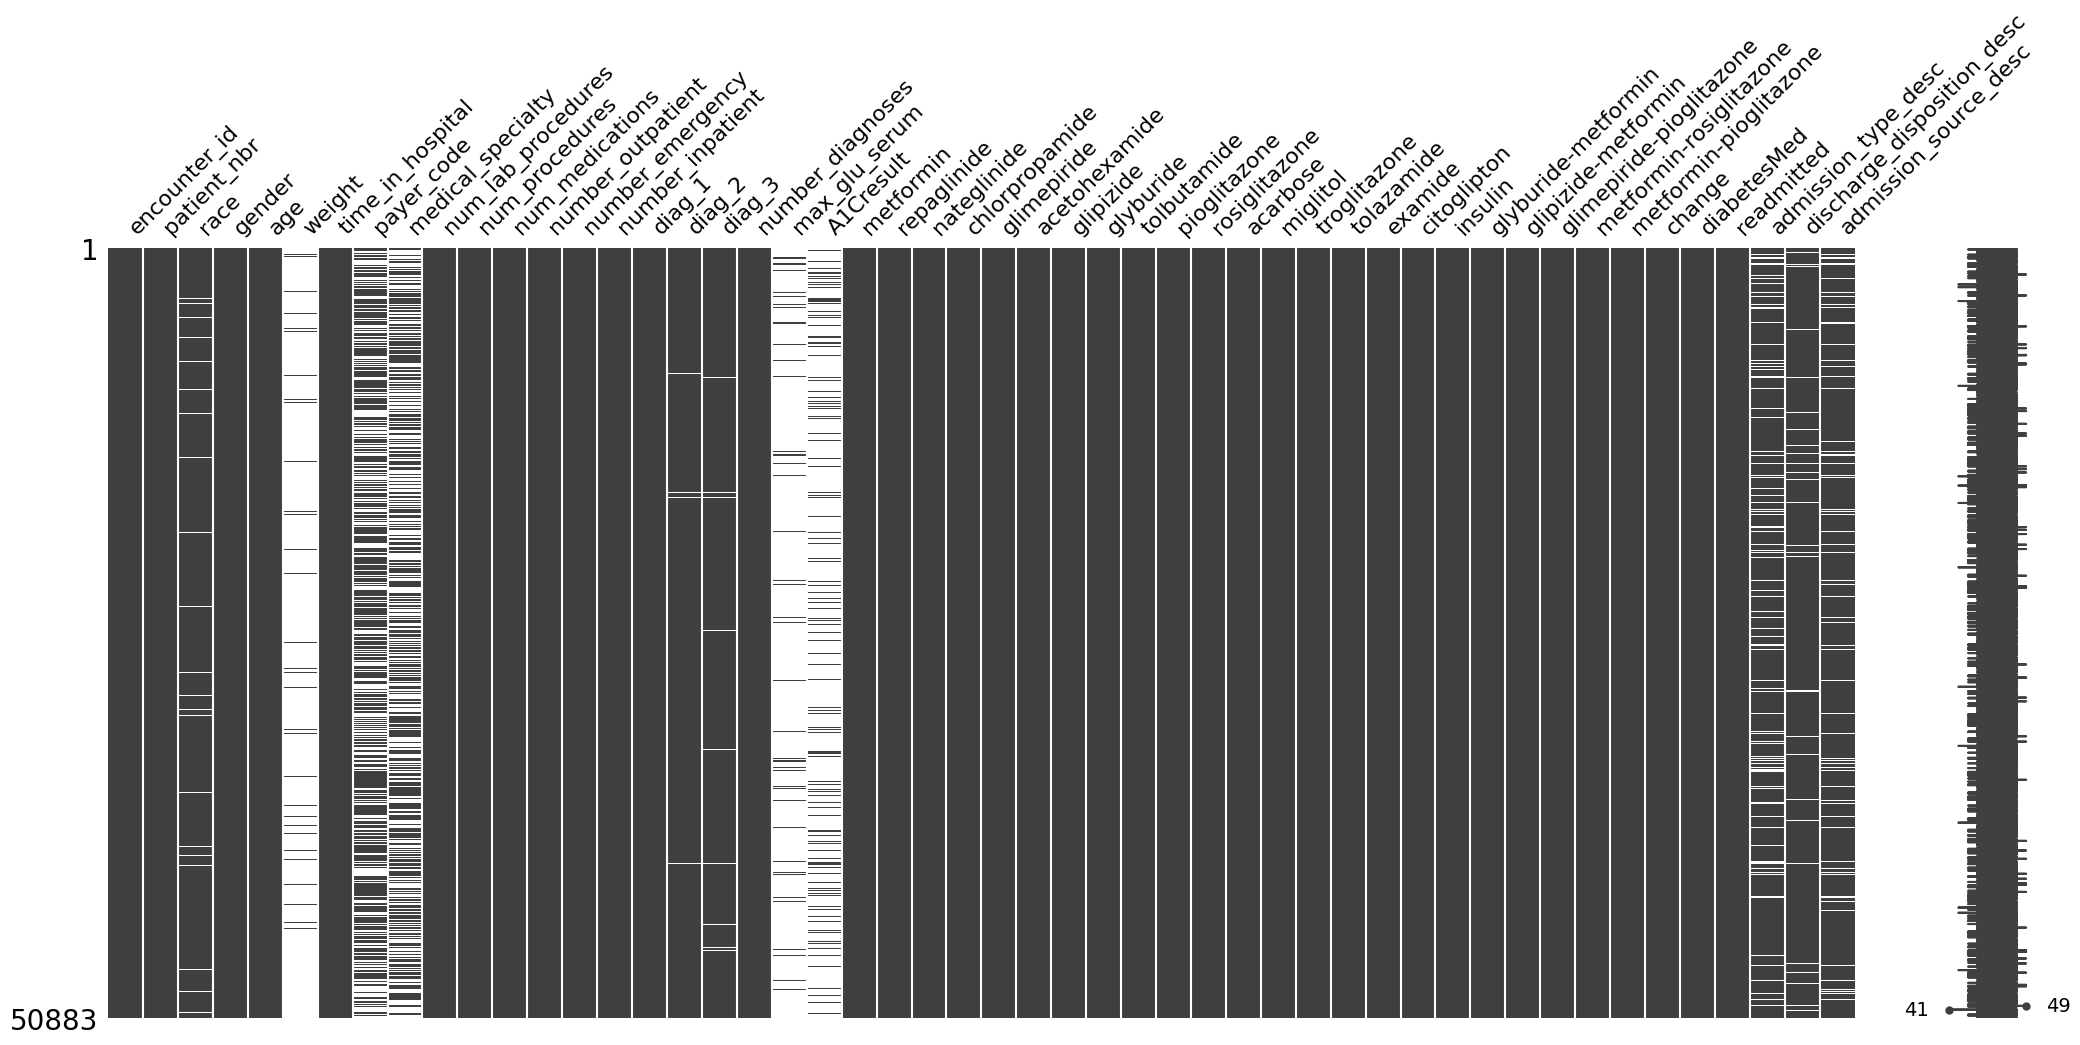

In [365]:
# Block 15: Missing Number Analysis

msno.matrix(df)

In [366]:
# Block 16: Get numeric and categorical features

# Split numeric and categorical
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(exclude='number').columns

# Get length of each df
print(f'Numeric df # of Columns: {len(numeric_cols)}')
print(f'Categorical df # of Columns: {len(categorical_cols)}')

Numeric df # of Columns: 11
Categorical df # of Columns: 39


In [367]:
# Block 17: Plot histograms of numeric features

# Get number of columns
num_cols = len(numeric_cols)

# Calculate the number of rows and columns for subplots
n_rows = (num_cols + 2) // 3 
n_cols = 3

# Create subplots
fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=numeric_cols)

# Add histograms to subplots
for i, col in enumerate(numeric_cols):
    row = i // n_cols + 1
    col_num = i % n_cols + 1
    fig.update_yaxes(title_text="Frequency", row=row, col=col_num)
    fig.update_xaxes(title_text="Feature Value", row=row, col=col_num)
    fig.add_trace(go.Histogram(x=df[col]), row=row, col=col_num)
    fig.update_traces(showlegend=False)

# Update layout
fig.update_layout(height=n_rows * 250, title_text="Histograms of Numeric Features")

fig.show()

In [368]:
# Block 18: Boxplots of categorical features (Non-Binary)

# Get non-binary categorical columns
nb_categorical_cols = [col for col in categorical_cols if df[col].nunique() > 2]

# Ensure the last three columns are "medical_specialty", "discharge_disposition_desc", and "admission_source_desc" for plot readability
nb_categorical_cols = [col for col in nb_categorical_cols if col not in ["medical_specialty", "discharge_disposition_desc", "admission_source_desc"]]
nb_categorical_cols.extend(["medical_specialty", "discharge_disposition_desc", "admission_source_desc"])

# Calculate the number of rows needed for three columns
num_nb_categorical_cols = len(nb_categorical_cols)
num_cols = 3
num_rows = (num_nb_categorical_cols + num_cols - 1) // num_cols

# Create subplots with three columns
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=nb_categorical_cols)

# Add bar plots to subplots
for i, col in enumerate(nb_categorical_cols):
    # Calculate row and column index
    row = i // num_cols + 1
    col_num = i % num_cols + 1

    # Count the frequency of each category including NaN values
    category_counts = df[col].value_counts(dropna=False).reset_index()
    category_counts.columns = [col, 'count']

    # Replace np.nan values with the string "NaN" so they appear in the plot
    category_counts[col] = category_counts[col].astype(str)

    # Add axis labels
    fig.update_yaxes(title_text="Frequency", row=row, col=col_num)
    fig.update_xaxes(title_text="Category", row=row, col=col_num)

    # Rotate x-axis ticks for long labels
    if col in ['medical_specialty', 'discharge_disposition_desc', 'admission_source_desc']:
        fig.update_xaxes(tickangle=90, row=row, col=col_num)

    # Create a bar plot trace
    trace = go.Bar(x=category_counts[col], y=category_counts['count'])

    # Add the trace to the subplot
    fig.add_trace(trace, row=row, col=col_num)

# Update layout
fig.update_layout(
    height=num_rows * 300,
    title_text="Bar Plots of Categorical Features (Non-Binary)",
    showlegend=False
)

fig.show()


In [369]:
# Block 19: Boxplots of categorical features (Binary)

# Select binary columns
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]

# Calculate the number of rows needed for two columns
num_binary_cols = len(binary_cols)
num_rows = (num_binary_cols + 1) // 2  

# Create subplots with two columns
fig = make_subplots(rows=num_rows, cols=2, subplot_titles=binary_cols)

# Add bar plots to subplots
for i, col in enumerate(binary_cols):
    # Calculate row and column index
    row = i // 2 + 1 
    col_num = i % 2 + 1  

    # Count the frequency of each category including NaN values
    category_counts = df[col].value_counts(dropna=False).reset_index()
    category_counts.columns = [col, 'count']

    # Replace np.nan values with the string "NaN" so they appear in the plot
    category_counts[col] = category_counts[col].astype(str)

    # Add axis labels
    fig.update_yaxes(title_text="Frequency", row=row, col=col_num)
    fig.update_xaxes(title_text="Category", row=row, col=col_num)

    # Rotate x-axis ticks for long lables
    if col in ['medical_specialty','discharge_disposition_desc','admission_source_desc']:
        fig.update_xaxes(tickangle=40, row=row, col=col_num) 
    
    # Create a bar plot trace
    trace = go.Bar(x=category_counts[col], y=category_counts['count'])

    # Add the trace to the subplot
    fig.add_trace(trace, row=row, col=col_num)

# Update layout
fig.update_layout(
    height=num_rows * 300,
    title_text="Bar Plots of Categorical Features (Binary)",
    showlegend=False
)

fig.show()

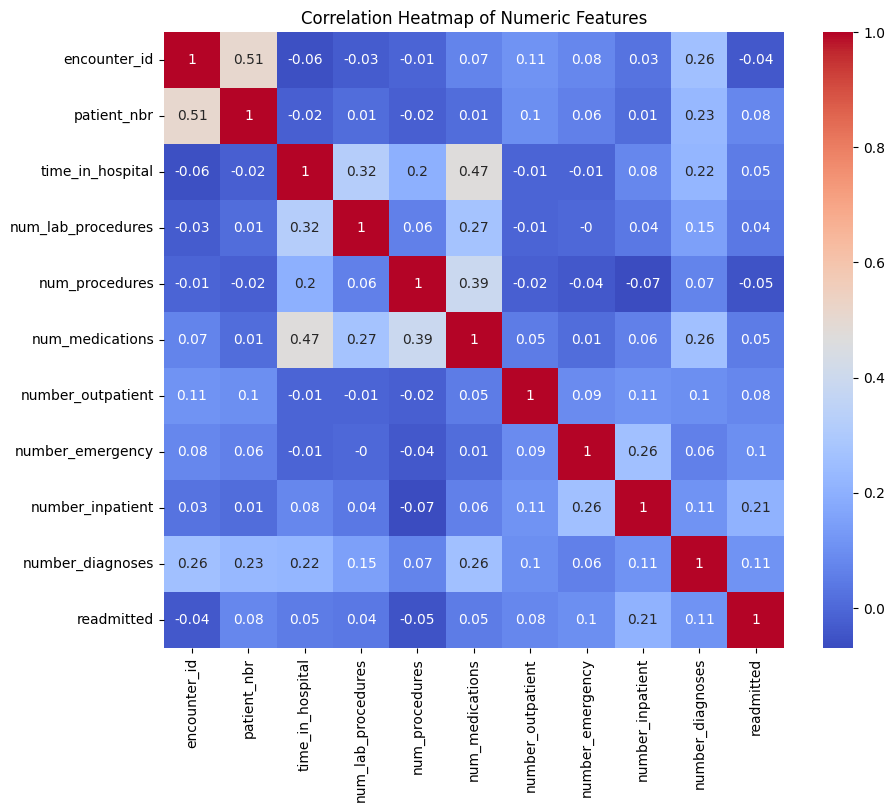

In [370]:
# Block 20: Get correlation heatplot

# Set figure size
plt.figure(figsize=(10, 8))

# Calculate correlation matrix
corr_matrix = round(df[numeric_cols].corr(),2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Data Preprocessing

In [371]:
# Block 21: Bucket discharge_disposition_desc to reduce cardinality

# Compute pre-transformation crosstabs
crosstab1 = pd.crosstab(df.discharge_disposition_desc, df.readmitted, normalize="index").sort_index(axis=1)

# Replace discharge disposition description which need to be manually mapped
df.discharge_disposition_desc.replace('Neonate discharged to another hospital for neonatal aftercare', 'Discharged_to_Facility',inplace=True)
df.discharge_disposition_desc.replace('Still patient or expected to return for outpatient services', 'Patient',inplace=True)
df.discharge_disposition_desc.replace('Admitted as an inpatient to this hospital', 'Patient',inplace=True)
df.discharge_disposition_desc.replace('Neonate discharged to another hospital for neonatal aftercare', 'Discharged_to_Facility',inplace=True)
df.discharge_disposition_desc.replace('Still patient or expected to return for outpatient services', 'Patient',inplace=True)
df.discharge_disposition_desc.replace('Discharged/transferred to home with home health service', 'Discharged_to_Home',inplace=True)
df.discharge_disposition_desc.replace('Discharged/transferred to home under care of Home IV provider', 'Discharged_to_Home',inplace=True)
df.discharge_disposition_desc.replace('Discharged to home', 'Discharged_to_Home',inplace=True)

# Keep only first word of discharge_disposition_desc
df['discharge_disposition_desc'] = df['discharge_disposition_desc'].str.split().str[0]

# Coalese similar categories
df['discharge_disposition_desc'] = df['discharge_disposition_desc'].replace('Discharged/transferred', 'Discharged_to_Facility')
df['discharge_disposition_desc'] = df['discharge_disposition_desc'].replace('Discharged/transferred/referred', 'Discharged_to_Facility')

In [372]:
# Block 22: Convert binned columns (age) to averages

# Create function to convert binned columns to averages
def parse_and_average(bin_str):
  # Extract integers
  numbers = list(map(int, re.findall(r'\d+', bin_str))) 
  
  # Compute the average
  return sum(numbers) / len(numbers) if numbers else np.nan 

# Converts categorical column to numeric using parse_and_average()
def convert_to_numeric(df,col_to_convert):
  """
  Converts categorical column to numeric using parse_and_average()
  """
  categories = df[col_to_convert].unique()
  category_mapping = {category: parse_and_average(category) for category in categories}
  df[col_to_convert] = df[col_to_convert].map(category_mapping)
  df[col_to_convert] = pd.to_numeric(df[col_to_convert], errors='coerce')
  return df

# Apply functions
convert_to_numeric(df,'age')

encounter_id  patient_nbr       race  gender   age     weight  \
0         278913204      2274813        NaN  Female  55.0        NaN   
1         130125492      4981140  Caucasian    Male  65.0        NaN   
2          77887872      5500116  Caucasian    Male  65.0        NaN   
3         414380618    112563099  Caucasian    Male  85.0        NaN   
4         329018342    122428580        NaN  Female  85.0        NaN   
...             ...          ...        ...     ...   ...        ...   
50878     184199616     60102693  Caucasian    Male  25.0        NaN   
50879     194553030     92158929  Caucasian    Male  65.0        NaN   
50880      68357706      3353715  Caucasian    Male  65.0        NaN   
50881     420828782     64714149  Caucasian    Male  55.0  [100-125)   
50882     102593604     23348376  Caucasian  Female  75.0        NaN   

       time_in_hospital payer_code medical_specialty  num_lab_procedures  ...  \
0                     7        NaN        Nephrology                  54  ...   
1                     4         MC               NaN                  51  ...   
2                     7        NaN        Nephrology                  56  ...   
3                     9         MC               NaN                  68  ...   
4                     6        NaN               NaN                  59  ...   
...                 ...        ...               ...                 ...  ...   
50878                 3         PO               NaN                  54  ...   
50879                 4         MC               NaN                  50  ...   
50880                 5        NaN  Emergency/Trauma                  62  ...   
50881                14         BC               NaN                  34  ...   
50882                 4        NaN  InternalMedicine                  39  ...   

       glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                       No                        No                       No   
1                       No                        No                       No   
2                       No                        No                       No   
3                       No                        No                       No   
4                       No                        No                       No   
...                    ...                       ...                      ...   
50878                   No                        No                       No   
50879                   No                        No                       No   
50880                   No                        No                       No   
50881                   No                        No                       No   
50882                   No                        No                       No   

       metformin-pioglitazone  change diabetesMed readmitted  \
0                          No      No          No          0   
1                          No      Ch         Yes          0   
2                          No      No         Yes          0   
3                          No      Ch         Yes          1   
4                          No      Ch         Yes          0   
...                       ...     ...         ...        ...   
50878                      No      Ch         Yes          0   
50879                      No      Ch         Yes          1   
50880                      No      No          No          0   
50881                      No      Ch         Yes          1   
50882                      No      No          No          1   

      admission_type_desc  discharge_disposition_desc  \
0               Emergency      Discharged_to_Facility   
1               Emergency          Discharged_to_Home   
2               Emergency          Discharged_to_Home   
3                Elective      Discharged_to_Facility   
4               Emergency      Discharged_to_Facility   
...                   ...                         ...   
50878           Emergency   

In [373]:
# Block 23: Drop columns

# Columns with no predictive power
df.drop(columns=['encounter_id','patient_nbr'], inplace=True)

# Columns with >50% missing data
missing_cols = df.columns[df.isnull().mean() > 0.50]
print(f'Number of columns with >25% missing data: {len(missing_cols)}: {missing_cols}')

# Drop columns from train and test
df.drop(columns=missing_cols, inplace=True)

# Remove constant columns
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f'Number of constant columns: {len(constant_cols)}: {constant_cols}')

# Drop constant cols from training and test
df.drop(columns=constant_cols, inplace=True)

# Drop columns with extreme class imbalance

# Find columns where one class dominates (>=99%)
imbalanced_cols = [col for col in df.columns if df[col].value_counts(normalize=True).iloc[0] >= 0.99]
print("Highly imbalanced columns (≥99% in one class):", imbalanced_cols)

# Drop columns
df.drop(columns=imbalanced_cols,inplace=True)

Number of columns with >25% missing data: 3: Index(['weight', 'max_glu_serum', 'A1Cresult'], dtype='object')
Number of constant columns: 4: ['acetohexamide', 'examide', 'citoglipton', 'metformin-pioglitazone']
Highly imbalanced columns (≥99% in one class): ['nateglinide', 'chlorpropamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone']


In [374]:
# Block 24: Categorize diagnosis columns

def categorize_icd9(code):
    try:
        if code.startswith(('E', 'V')):
            return 'external causes of injury and supplemental classification'
        num_code = float(code)  # Convert to float to handle decimal values

        if 1 <= num_code <= 139:
            return 'infectious and parasitic diseases'
        elif 140 <= num_code <= 239:
            return 'neoplasms'
        elif 240 <= num_code <= 279:
            return 'endocrine, nutritional and metabolic diseases, and immunity disorders'
        elif 280 <= num_code <= 289:
            return 'diseases of the blood and blood-forming organs'
        elif 290 <= num_code <= 319:
            return 'mental disorders'
        elif 320 <= num_code <= 389:
            return 'diseases of the nervous system and sense organs'
        elif 390 <= num_code <= 459:
            return 'diseases of the circulatory system'
        elif 460 <= num_code <= 519:
            return 'diseases of the respiratory system'
        elif 520 <= num_code <= 579:
            return 'diseases of the digestive system'
        elif 580 <= num_code <= 629:
            return 'diseases of the genitourinary system'
        elif 630 <= num_code <= 679:
            return 'complications of pregnancy, childbirth, and the puerperium'
        elif 680 <= num_code <= 709:
            return 'diseases of the skin and subcutaneous tissue'
        elif 710 <= num_code <= 739:
            return 'diseases of the musculoskeletal system and connective tissue'
        elif 740 <= num_code <= 759:
            return 'congenital anomalies'
        elif 760 <= num_code <= 779:
            return 'certain conditions originating in the perinatal period'
        elif 780 <= num_code <= 799:
            return 'symptoms, signs, and ill-defined conditions'
        elif 800 <= num_code <= 999:
            return 'injury and poisoning'
        else:
            return 'unknown' # Keeping unknowns as a category
    except ValueError:
        return np.nan

# Apply function to three diagnosis columns
df['diag_1'] = df['diag_1'].astype(str).apply(categorize_icd9)
df['diag_2'] = df['diag_2'].astype(str).apply(categorize_icd9)
df['diag_3'] = df['diag_3'].astype(str).apply(categorize_icd9)

In [375]:
# Block 25: Condense highly sparse categories into "Other"

def get_rare_categories(df, threshold=0.001):
    """
    Identifies rare categories in all categorical columns of a DataFrame.
    Categories that appear in <= threshold proportion of the dataset are considered rare.
    """
    rare_categories = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        value_counts = df[col].value_counts(normalize=True)
        rare = set(value_counts[value_counts <= threshold].index)
        if len(rare) > 1:  # Only store rare categories if there's more than one
            rare_categories[col] = rare

    return rare_categories

def condense_categories(df, rare_categories):
    """
    Condenses rare categories in all categorical columns of a DataFrame using a predefined mapping.
    """
    df = df.copy()
    for col, categories in rare_categories.items():
        df[col] = df[col].replace(categories, "Other")

    return df

# Calculate rare categories
rare_categories= get_rare_categories(df)
for col, categories in rare_categories.items():
    print(f"{col}: {categories}")
df = condense_categories(df, rare_categories)

# Print dictionary of columns and their rare categories
print("Rare categories:", rare_categories)

medical_specialty: {'Pediatrics-Pulmonology', 'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck', 'Resident', 'Pediatrics-Hematology-Oncology', 'Dermatology', 'Osteopath', 'Surgery-Maxillofacial', 'Cardiology-Pediatric', 'Pediatrics-AllergyandImmunology', 'Obsterics&Gynecology-GynecologicOnco', 'Endocrinology-Metabolism', 'DCPTEAM', 'Surgery-Pediatric', 'SurgicalSpecialty', 'Perinatology', 'Anesthesiology-Pediatric', 'Ophthalmology', 'Psychiatry-Child/Adolescent', 'Gynecology', 'Anesthesiology', 'Obstetrics', 'Radiology', 'Pediatrics-Neurology', 'Pathology', 'AllergyandImmunology', 'Neurophysiology', 'PhysicianNotFound', 'Surgery-Colon&Rectal', 'InfectiousDiseases', 'Rheumatology', 'OutreachServices', 'Dentistry'}
diag_1: {'unknown', 'congenital anomalies'}
admission_type_desc: {'Newborn', 'Trauma Center'}
admission_source_desc: {'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Court/Law Enforcement', 'Extramural Birth', 'Transfe

In [376]:
# Block 26: Boxplots of categorical features

# Seelct categorical features
categorical_cols = df.select_dtypes(exclude='number').columns

# Calculate the number of rows needed for two columns
num_categorical_cols = len(categorical_cols)
num_rows = (num_categorical_cols + 1) // 2  

# Create subplots with two columns
fig = make_subplots(rows=num_rows, cols=2, subplot_titles=categorical_cols)

# Add bar plots to subplots
for i, col in enumerate(categorical_cols):
    # Calculate row and column index
    row = i // 2 + 1 
    col_num = i % 2 + 1 

    # Count the frequency of each category
    category_counts = df[col].value_counts().reset_index()
    category_counts.columns = [col, 'count']

    # Create a bar plot trace
    trace = go.Bar(x=category_counts[col], y=category_counts['count'])

    # Add the trace to the subplot
    fig.add_trace(trace, row=row, col=col_num)

    # Adjust x-axes for plotting
    fig.update_xaxes(
        tickmode='array',
        tickvals=category_counts[col],
        ticktext=[label[:25] + "..." if len(label) > 25 else label for label in category_counts[col]],
        row=row,
        col=col_num
    )

# Update layout for better visualization
fig.update_layout(height=num_rows * 300
                  ,title_text="Bar Plots of Categorical Features After Transformations"
                  ,showlegend=False
                  ,xaxis_tickangle=-45 
                  )

fig.show()

In [377]:
# Block 27: Log transform right-skewed numeric variables

# Select numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Identify right-skewed columns
skewness = df[numeric_cols].skew()
right_skewed_cols = skewness[skewness > 1].index
print("Right-skewed columns:", right_skewed_cols)

# Log transform right-skewed columns
df[right_skewed_cols] = np.log1p(df[right_skewed_cols])

Right-skewed columns: Index(['time_in_hospital', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient'],
      dtype='object')


In [378]:
# Block 28: Plot histograms of numeric features with log transform

# Get number of columns
num_cols = len(right_skewed_cols)

# Calculate the number of rows and columns for subplots
n_rows = (num_cols + 2) // 3  
n_cols = 3

# Create subplots
fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=numeric_cols)

# Add histograms to subplots
for i, col in enumerate(right_skewed_cols):
    row = i // n_cols + 1
    col_num = i % n_cols + 1
    fig.add_trace(go.Histogram(x=df[col]), row=row, col=col_num)

# Update layout
fig.update_layout(height=n_rows * 250, title_text="Histograms of Right-Skewed Numeric Features After Log Transformation")

fig.show()

In [379]:
# Block 29: Identify left-skewed columns
left_skewed_cols = skewness[skewness < -1].index
print("Left-skewed columns:", left_skewed_cols)

# Apply power transformation (square) to left-skewed columns
df[left_skewed_cols] = np.power(df[left_skewed_cols], 2)

# No left-skewed columns

Left-skewed columns: Index([], dtype='object')


In [380]:
# Block 30: Get null % of each column
print("Columns with missing data:")
for col in df.columns:
    if df[col].isnull().mean() > 0:
        print(f'{col}: {round(df[col].isnull().mean(),5)*100}%')

Columns with missing data:
race: 2.252%
gender: 0.004%
payer_code: 39.465%
medical_specialty: 49.04%
admission_type_desc: 10.389%
discharge_disposition_desc: 4.64%
admission_source_desc: 7.106%


# Modeling Pipeline

In [301]:
# Block 31: Modeling definitions

# Define models
models = {
    "SVC": {"model": LinearSVC(random_state=24112897, class_weight='balanced', max_iter=5000)},
    "Lasso": {"model": LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', random_state=24112897, max_iter=5000)},
    "Random Forest": {"model": RandomForestClassifier(random_state=24112897, class_weight='balanced')},
}

# Define hyperparameter grids
param_grids = {
    'SVC': {'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]},
    'Lasso': {'logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]},
    'Random Forest': {'randomforestclassifier__n_estimators': [50, 100, 300, 500, 800],
                      'randomforestclassifier__max_depth': [5, 10, 15, 20]}
}

# Get total number of fits (all hyperparameter combinations across models)
total_fits = sum(
    len(list(product(*params.values()))) for params in param_grids.values()
)
print(f"Total number of fits: {total_fits}")

# Get breakdown by model
for model, params in param_grids.items():
    num_fits = len(list(product(*params.values())))
    print(f"    Number of fits for {model}: {num_fits}")

Total number of fits: 32
    Number of fits for SVC: 6
    Number of fits for Lasso: 6
    Number of fits for Random Forest: 20


In [302]:
# Block 32: Modeling Pipeline

# Separate the target variable
X = df.drop(columns='readmitted')
y = df['readmitted']

# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=24112897)

# Dictionary to store train/test indices for each outer fold
outer_fold_indices = {}

# Store results
results = {}

# Outer CV loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"Nested CV Outer Fold {outer_fold}")
    
    # Store the indices for this fold
    outer_fold_indices[outer_fold] = {'train_idx': train_idx, 'test_idx': test_idx}

    # Split train and test
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Get numeric and categorical columns
    numeric_cols = X_train.select_dtypes(include='number').columns
    categorical_cols = X_train.select_dtypes(exclude='number').columns

    # Create numeric pipeline
    numeric_pipeline = Pipeline([("scaler", MinMaxScaler())])

    # Create categorical pipeline
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
        ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine both pipelines
    preprocessor = ColumnTransformer([
        ("numerical", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ], verbose_feature_names_out=False)
    
    # Track best models for this outer fold
    outer_fold_best_models = {}
    
    # Use a different random state for inner CV in each outer fold
    inner_cv_random_state = 24112897 + outer_fold

    # Inner loop for model selection
    pbar = tqdm(list(models.items()), desc="Training Models", leave=True)
    for model_name, model_data in pbar:
        # Construct pipeline
        pipeline = make_pipeline(preprocessor, model_data['model'])

        # Get parameter grids for grid search
        param_grid = param_grids.get(model_name, {})

        # Perform grid search with inner CV
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=inner_cv_random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1', n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)

        # Initialize keys in results if they don't exist yet
        if model_name not in results:
            results[model_name] = {
                'outer_fold_cv_results': [],
                'best_models': [],
                'test_scores': [],
                'confusion_matrices': [],
                'roc_curves': []
            }
        
        # Store all CV results for this model in this outer fold
        results[model_name]['outer_fold_cv_results'].append({
            'outer_fold': outer_fold,
            'cv_results': pd.DataFrame(grid_search.cv_results_)
        })
        
        # Get best model for this algorithm in this outer fold
        best_model = grid_search.best_estimator_
        outer_fold_best_models[model_name] = best_model
        
        # Store best model hyperparameters, CV scores, and the trained model
        results[model_name]['best_models'].append({
            'outer_fold': outer_fold,
            'model_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'trained_model': best_model
        })

        # Update the progress bar
        pbar.set_postfix({
            'model': model_name
        })
    
    # Test all best models on the test set for this outer fold
    for model_name, best_model in outer_fold_best_models.items():
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        metrics = {
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'accuracy': accuracy_score(y_test, y_pred)
        }
        
        # Store test scores
        results[model_name]['test_scores'].append({
            'outer_fold': outer_fold,
            'metrics': metrics
        })
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        results[model_name]['confusion_matrices'].append({
            'outer_fold': outer_fold,
            'confusion_matrix': cm
        })
        
        # Calculate ROC curve and AUC
        try:
            y_proba = best_model.predict_proba(X_test)[:, 1]
        except AttributeError:
            y_proba = best_model.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        results[model_name]['roc_curves'].append({
            'outer_fold': outer_fold,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds,
            'auc': roc_auc
        })
        
        # Print best model hyperparameters, CV scores, and the trained model
        tqdm.write(f"  {model_name} Best Model:")
        tqdm.write(f"    Best Params: {results[model_name]['best_models'][-1]['model_params']}")
        tqdm.write(f"    CV F1 Score: {results[model_name]['best_models'][-1]['cv_score']:.4f}")
        tqdm.write(f"       Test F1 Score: {metrics['f1']:.4f}")
        tqdm.write(f"       Test Accuracy: {metrics['accuracy']:.4f}")
        
    print() 


Nested CV Outer Fold 1


Training Models: 100%|██████████| 3/3 [05:41<00:00, 113.96s/it, model=Random Forest]


  SVC Best Model:
    Best Params: {'linearsvc__C': 1000}
    CV F1 Score: 0.6054
       Test F1 Score: 0.6352
       Test Accuracy: 0.6352
  Lasso Best Model:
    Best Params: {'logisticregression__C': 100}
    CV F1 Score: 0.6061
       Test F1 Score: 0.6353
       Test Accuracy: 0.6353
  Random Forest Best Model:
    Best Params: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 300}
    CV F1 Score: 0.6085
       Test F1 Score: 0.6443
       Test Accuracy: 0.6443

Nested CV Outer Fold 2


Training Models: 100%|██████████| 3/3 [05:15<00:00, 105.05s/it, model=Random Forest]


  SVC Best Model:
    Best Params: {'linearsvc__C': 0.01}
    CV F1 Score: 0.6046
       Test F1 Score: 0.6331
       Test Accuracy: 0.6330
  Lasso Best Model:
    Best Params: {'logisticregression__C': 10}
    CV F1 Score: 0.6052
       Test F1 Score: 0.6333
       Test Accuracy: 0.6332
  Random Forest Best Model:
    Best Params: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 500}
    CV F1 Score: 0.6104
       Test F1 Score: 0.6391
       Test Accuracy: 0.6387

Nested CV Outer Fold 3


Training Models: 100%|██████████| 3/3 [05:58<00:00, 119.34s/it, model=Random Forest]


  SVC Best Model:
    Best Params: {'linearsvc__C': 0.01}
    CV F1 Score: 0.5996
       Test F1 Score: 0.6389
       Test Accuracy: 0.6391
  Lasso Best Model:
    Best Params: {'logisticregression__C': 1000}
    CV F1 Score: 0.6014
       Test F1 Score: 0.6389
       Test Accuracy: 0.6390
  Random Forest Best Model:
    Best Params: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 300}
    CV F1 Score: 0.6108
       Test F1 Score: 0.6426
       Test Accuracy: 0.6425



In [303]:
# Block 33: Calculate and print summary statistics

print("Summary of Results:")
for model_name in results:
    # CV scores
    cv_scores = [model_data['cv_score'] for model_data in results[model_name]['best_models']]
    
    # Test scores for each metric
    test_metrics = {}
    for metric in ['f1', 'accuracy']:
        metric_scores = [score_data['metrics'][metric] for score_data in results[model_name]['test_scores']]
        test_metrics[metric] = (np.mean(metric_scores), np.std(metric_scores))
    
    # Print summary
    print(f"{model_name}:")
    print(f"  Average CV Score (f1): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    print("  Test Scores (avg ± std):")
    for metric, (mean, std) in test_metrics.items():
        print(f"    {metric}: {mean:.4f} ± {std:.4f}")
    
    print()

Summary of Results:
SVC:
  Average CV Score (f1): 0.6032 ± 0.0026
  Test Scores (avg ± std):
    f1: 0.6358 ± 0.0024
    accuracy: 0.6358 ± 0.0025

Lasso:
  Average CV Score (f1): 0.6042 ± 0.0020
  Test Scores (avg ± std):
    f1: 0.6358 ± 0.0023
    accuracy: 0.6358 ± 0.0024

Random Forest:
  Average CV Score (f1): 0.6099 ± 0.0010
  Test Scores (avg ± std):
    f1: 0.6420 ± 0.0022
    accuracy: 0.6418 ± 0.0023



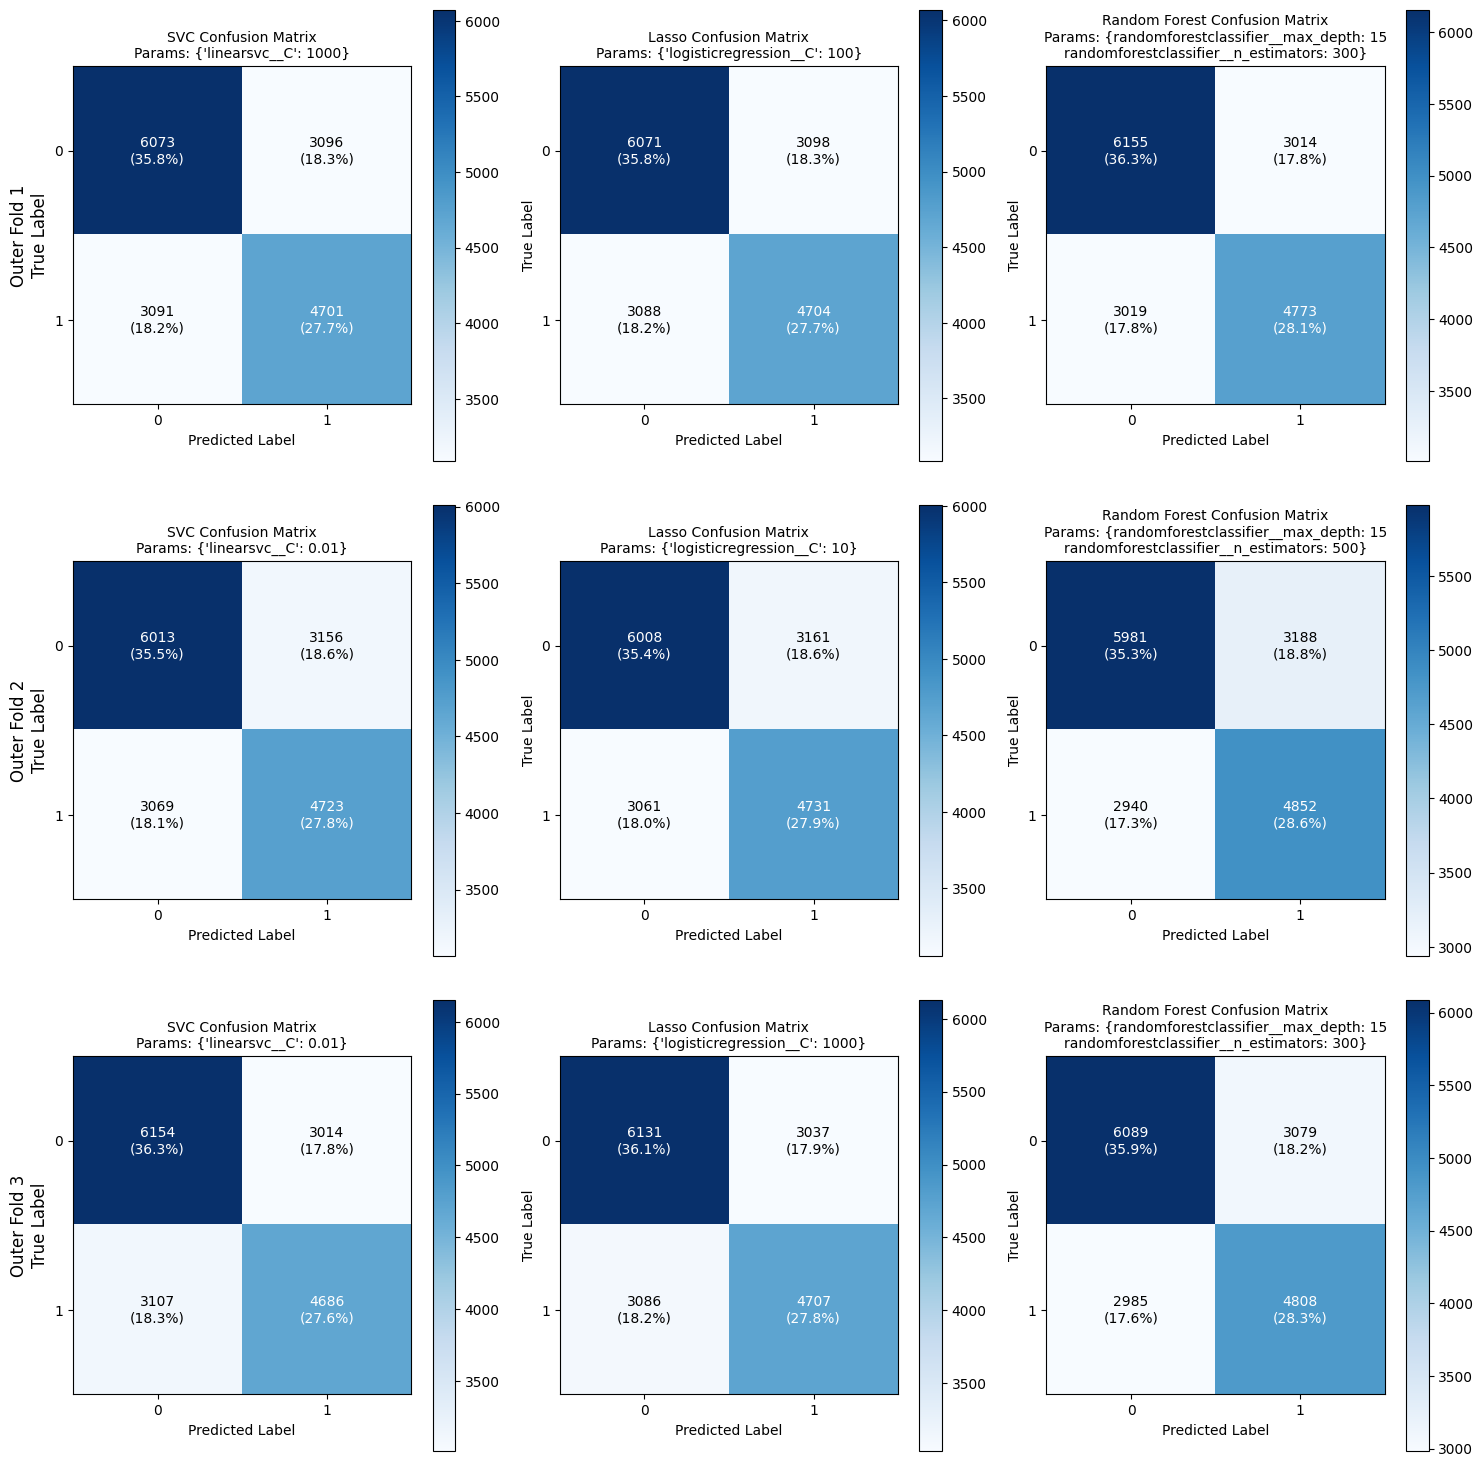

In [304]:
# Block 34: Plot confusion matrices

# Define models and folds
model_names = list(results.keys()) 
outer_folds = [1, 2, 3]

# Create a 3x3 grid for confusion matrices
fig, axes = plt.subplots(nrows=len(outer_folds), ncols=len(model_names), figsize=(15, 15))

# Loop over outer folds and models
for i, fold in enumerate(outer_folds):
    for j, model_name in enumerate(model_names):
        ax = axes[i, j]
        
        # Extract the confusion matrix for the current model and outer fold
        cm_entry = [entry for entry in results[model_name]['confusion_matrices'] if entry['outer_fold'] == fold]
        cm = cm_entry[0]['confusion_matrix']

        # Plot the confusion matrix
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        # Retrieve the hyperparameters for the best model in this fold for labeling
        best_entry = [entry for entry in results[model_name]['best_models'] if entry['outer_fold'] == fold]
        params = best_entry[0]['model_params'] if best_entry else {}

        # Split random forest parameter string into two lines for better readability
        if isinstance(params, dict) and len(params) == 2:
            param_str = "{"+"\n".join([f"{key}: {value}" for key, value in params.items()])+ "}"
        else:
            param_str = str(params)
        
        # Set title with model name and hyperparameters
        ax.set_title(f"{model_name} Confusion Matrix\nParams: {param_str}", fontsize=10)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_xticks(np.arange(cm.shape[1]))
        ax.set_yticks(np.arange(cm.shape[0]))
        
        # Annotate each cell with its count and percentage
        total = cm.sum()
        for k in range(cm.shape[0]):
            for l in range(cm.shape[1]):
                count = cm[k, l]
                percent = count / total * 100 if total > 0 else 0
                color = "white" if k == l else "black"
                ax.text(l, k, f"{count:d}\n({percent:.1f}%)",
                        ha="center", va="center",
                        color=color)
    
    # Label each row with the outer fold number
    axes[i, 0].set_ylabel(f"Outer Fold {fold}\nTrue Label", fontsize=12)

plt.tight_layout()
plt.show()


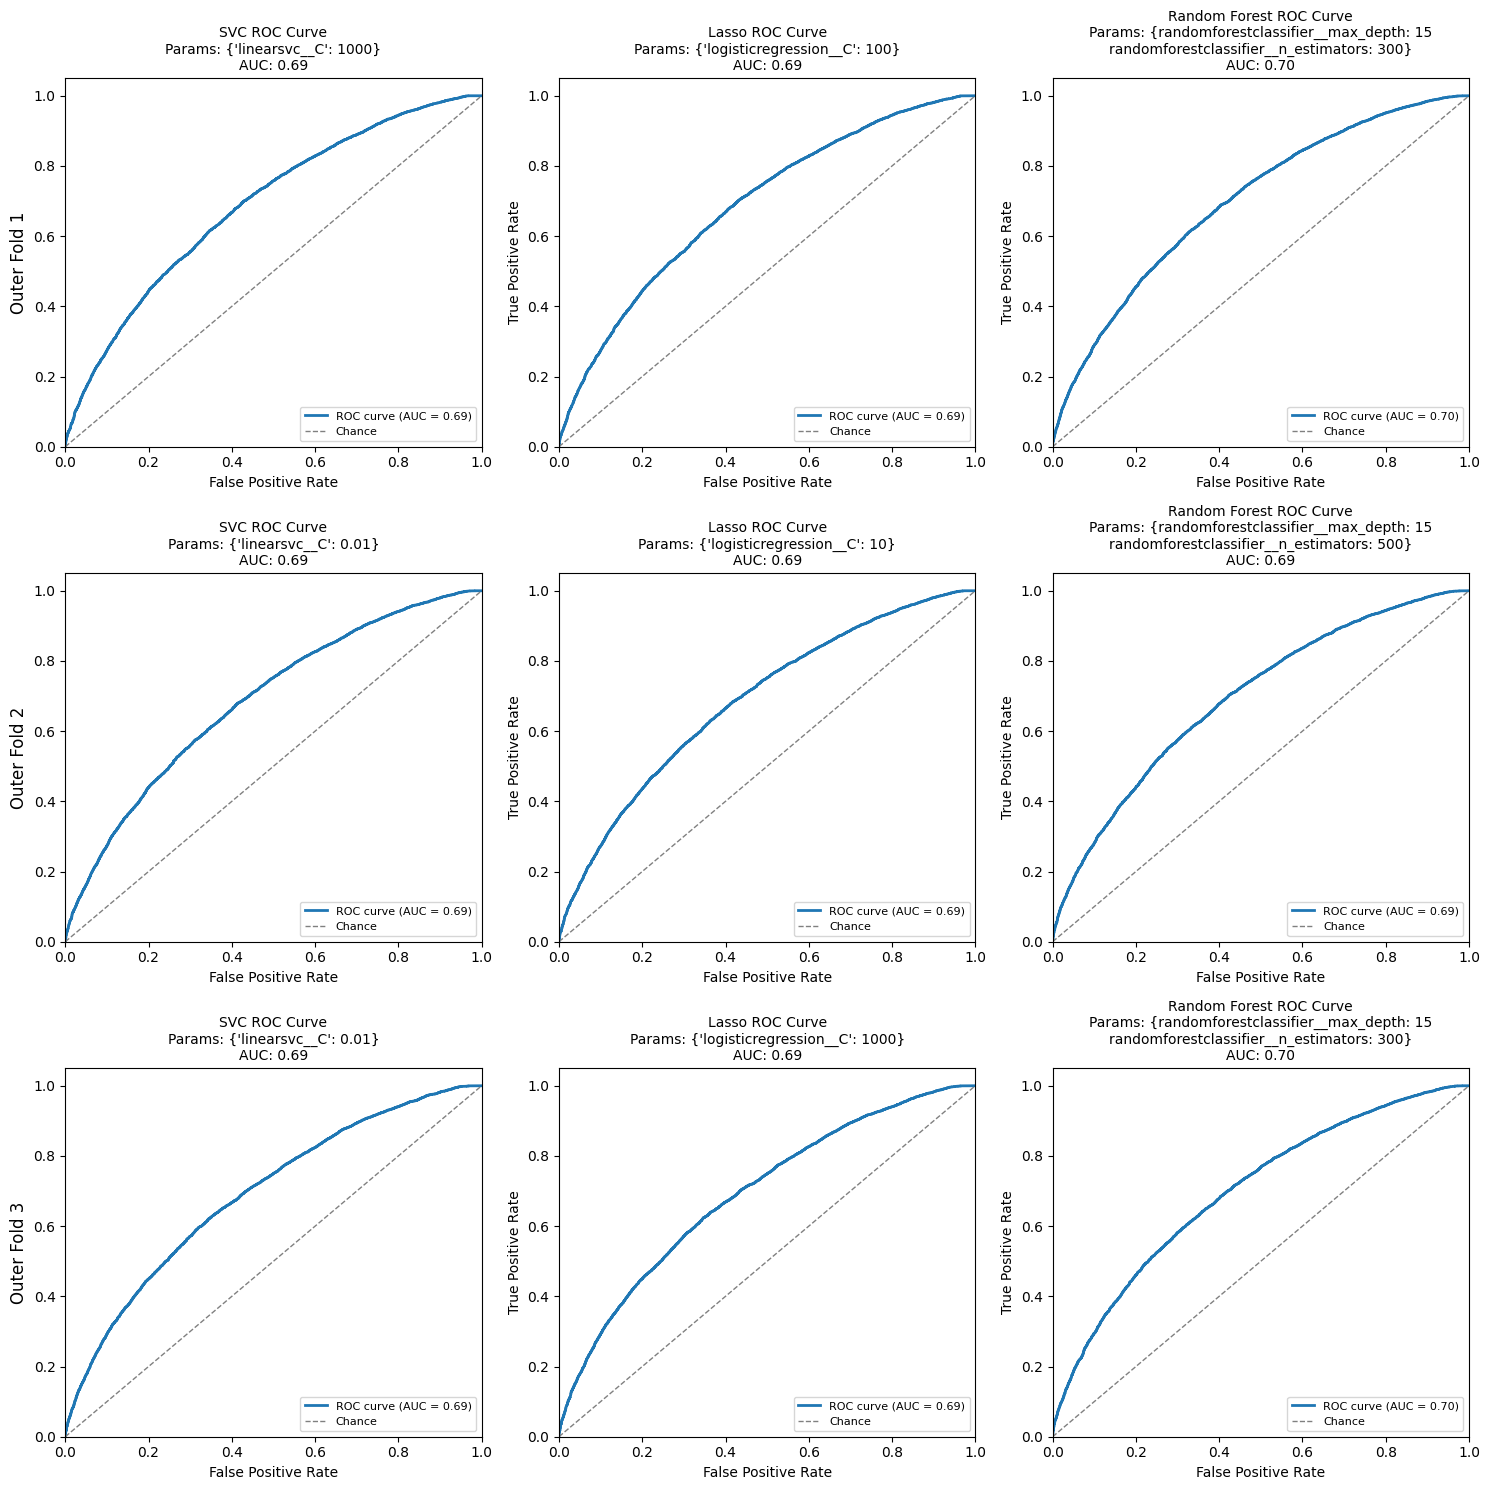

In [305]:
# Block 35: Plot ROC curves

# Create a 3x3 grid for ROC curves
fig, axes = plt.subplots(nrows=len(outer_folds), ncols=len(model_names), figsize=(15, 15))

# Loop over outer folds and models
for i, fold in enumerate(outer_folds):
    for j, model_name in enumerate(model_names):
        ax = axes[i, j]
        
        # Retrieve the ROC curve data for the current model and outer fold
        roc_entry = [entry for entry in results[model_name]['roc_curves'] if entry['outer_fold'] == fold]
        roc_data = roc_entry[0]
        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        roc_auc = roc_data['auc']
    
        # Retrieve best model parameters for the current fold for labeling
        best_entry = [entry for entry in results[model_name]['best_models'] if entry['outer_fold'] == fold]
        params = best_entry[0]['model_params'] 
        
        # Plot the ROC curve
        ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right", fontsize=8)

        # Split random forest parameter string into two lines for better readability
        if isinstance(params, dict) and len(params) == 2:
            param_str = "{"+"\n".join([f"{key}: {value}" for key, value in params.items()])+ "}"
        else:
            param_str = str(params)
        
        # Set title 
        ax.set_title(f"{model_name} ROC Curve\nParams: {param_str}\nAUC: {roc_auc:.2f}", fontsize=10)
    
    # Label each row with the outer fold number
    axes[i, 0].set_ylabel(f"Outer Fold {fold}", fontsize=12)

plt.tight_layout()
plt.show()


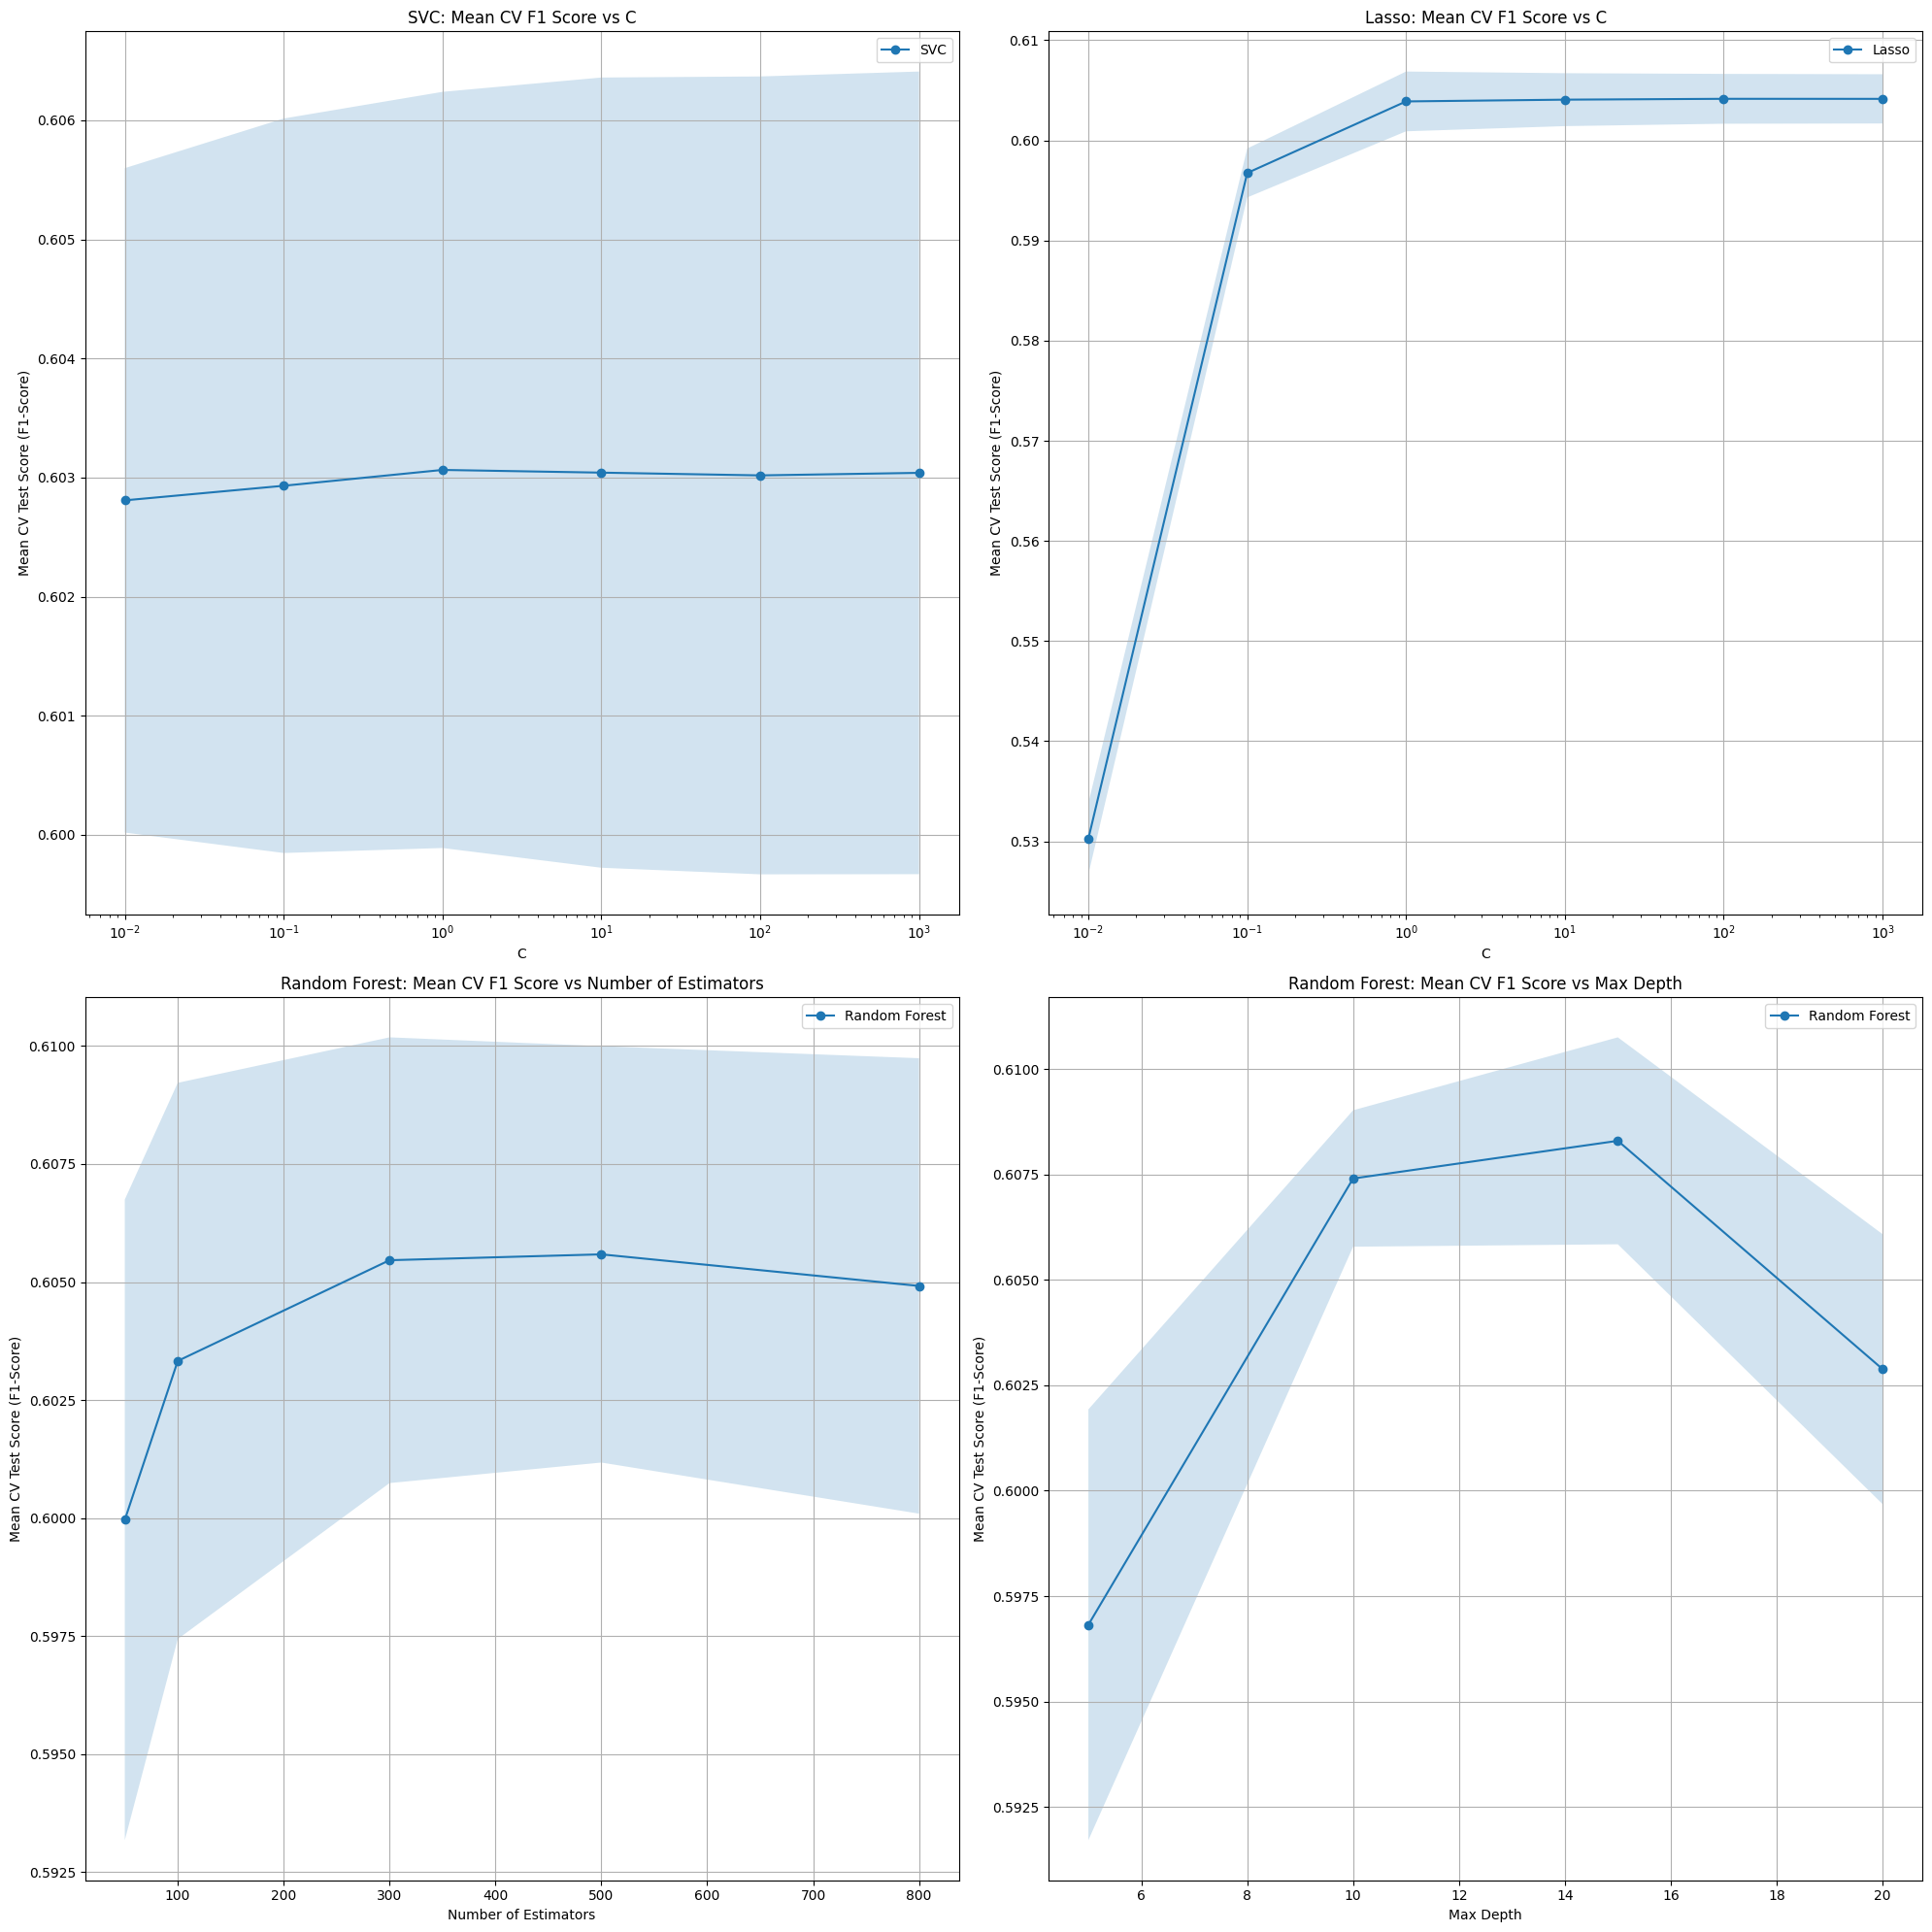

In [310]:
# Block 36: Plot hyperparameter performance

# Define subplot grid
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()
plot_idx = 0

# Loop through models and plot hyperparameter tuning results
for model_name, model_data in results.items():
    
    # Collect all CV results across outer folds
    all_cv_results = pd.concat([fold['cv_results'] for fold in model_data['outer_fold_cv_results']], ignore_index=True)

    # Identify relevant hyperparameters
    if model_name == 'SVC':
        param_names = ['param_linearsvc__C']
    elif model_name == 'Random Forest':
        param_names = ['param_randomforestclassifier__n_estimators', 'param_randomforestclassifier__max_depth']
    elif model_name == 'Lasso':
        param_names = ['param_logisticregression__C']
    else:
        continue  

    # Loop through each hyperparameter and create plots
    for param_name in param_names:
        
        # Compute mean, std, and count per hyperparameter value across outer folds
        param_stats = (
            all_cv_results.groupby(param_name)['mean_test_score']
            .agg(['mean', 'std', 'count'])
            .reset_index()
        )

        # Select subplot
        ax = axes[plot_idx] 

        # Plot with error bars
        ax.plot(param_stats[param_name], param_stats['mean'], marker='o', label=model_name)
        ax.fill_between(param_stats[param_name], param_stats['mean'] - param_stats['std'], param_stats['mean'] + param_stats['std'], alpha=0.2)

        # Use log scale for parameters tested on wide grid
        if any(keyword in param_name for keyword in ["C"]):
            ax.set_xscale('log')

        # Format parameter name for plotting
        if 'linearsvc__C' in param_name:
            param_str = 'C'
        elif 'logisticregression__C' in param_name:
            param_str = 'C'
        elif 'randomforestclassifier__n_estimators' in param_name:
            param_str = 'Number of Estimators'
        elif 'randomforestclassifier__max_depth' in param_name:
            param_str = 'Max Depth'

        # Update layout
        ax.set_title(f'{model_name}: Mean CV F1 Score vs {param_str}')
        ax.set_xlabel(param_str)
        ax.set_ylabel('Mean CV Test Score (F1-Score)')
        ax.grid(True)
        ax.legend()

        plot_idx += 1 
        if plot_idx >= len(axes):
            break  # Stop if all subplots are filled

plt.tight_layout()
plt.show()


In [307]:
# Block 37: Compare CV vs Test Performance

# Extract average CV scores and standard deviations from inner CV
avg_cv_scores = {}
avg_cv_std = {}

for model_name, model_results in results.items():
    all_cv_scores = [fold['cv_score'] for fold in model_results['best_models']]
    avg_cv_scores[model_name] = np.mean(all_cv_scores)
    avg_cv_std[model_name] = np.std(all_cv_scores)

# Extract average test scores and standard deviations from outer test set evaluation
avg_test_scores = {}
avg_test_std = {}

for model_name, model_results in results.items():
    all_test_scores = [fold['metrics']['f1'] for fold in model_results['test_scores']]
    avg_test_scores[model_name] = np.mean(all_test_scores)
    avg_test_std[model_name] = np.std(all_test_scores)

# Convert to DataFrame for plotting
summary_df = pd.DataFrame({
    'Model': list(avg_test_scores.keys()),
    'Avg CV Score': list(avg_cv_scores.values()),
    'CV Score Std': list(avg_cv_std.values()),
    'Avg Test Score': list(avg_test_scores.values()),
    'Test Score Std': list(avg_test_std.values())
})

# Create Plotly figure
fig = go.Figure()

# Add Avg CV Score bar trace
fig.add_trace(go.Bar(
    name='Avg CV Score',
    x=summary_df['Model'],
    y=summary_df['Avg CV Score'],
    error_y=dict(type='data', array=summary_df['CV Score Std']),
    marker_color='blue',
    opacity=0.6
))

# Add Avg Test Score bar trace
fig.add_trace(go.Bar(
    name='Avg Test Score',
    x=summary_df['Model'],
    y=summary_df['Avg Test Score'],
    error_y=dict(type='data', array=summary_df['Test Score Std']),
    marker_color='red',
    opacity=0.6
))

# Update layout
fig.update_layout(
    title='Model Comparison: Avg CV Score vs Avg Test Score with Standard Deviation',
    xaxis_title='Model',
    yaxis_title='F1 Score',
    barmode='group'
)

# Show figure
fig.show()

# Something is wrong above -- these values arent matching the summary above

# Final Modeling Pipeline (Best Model)

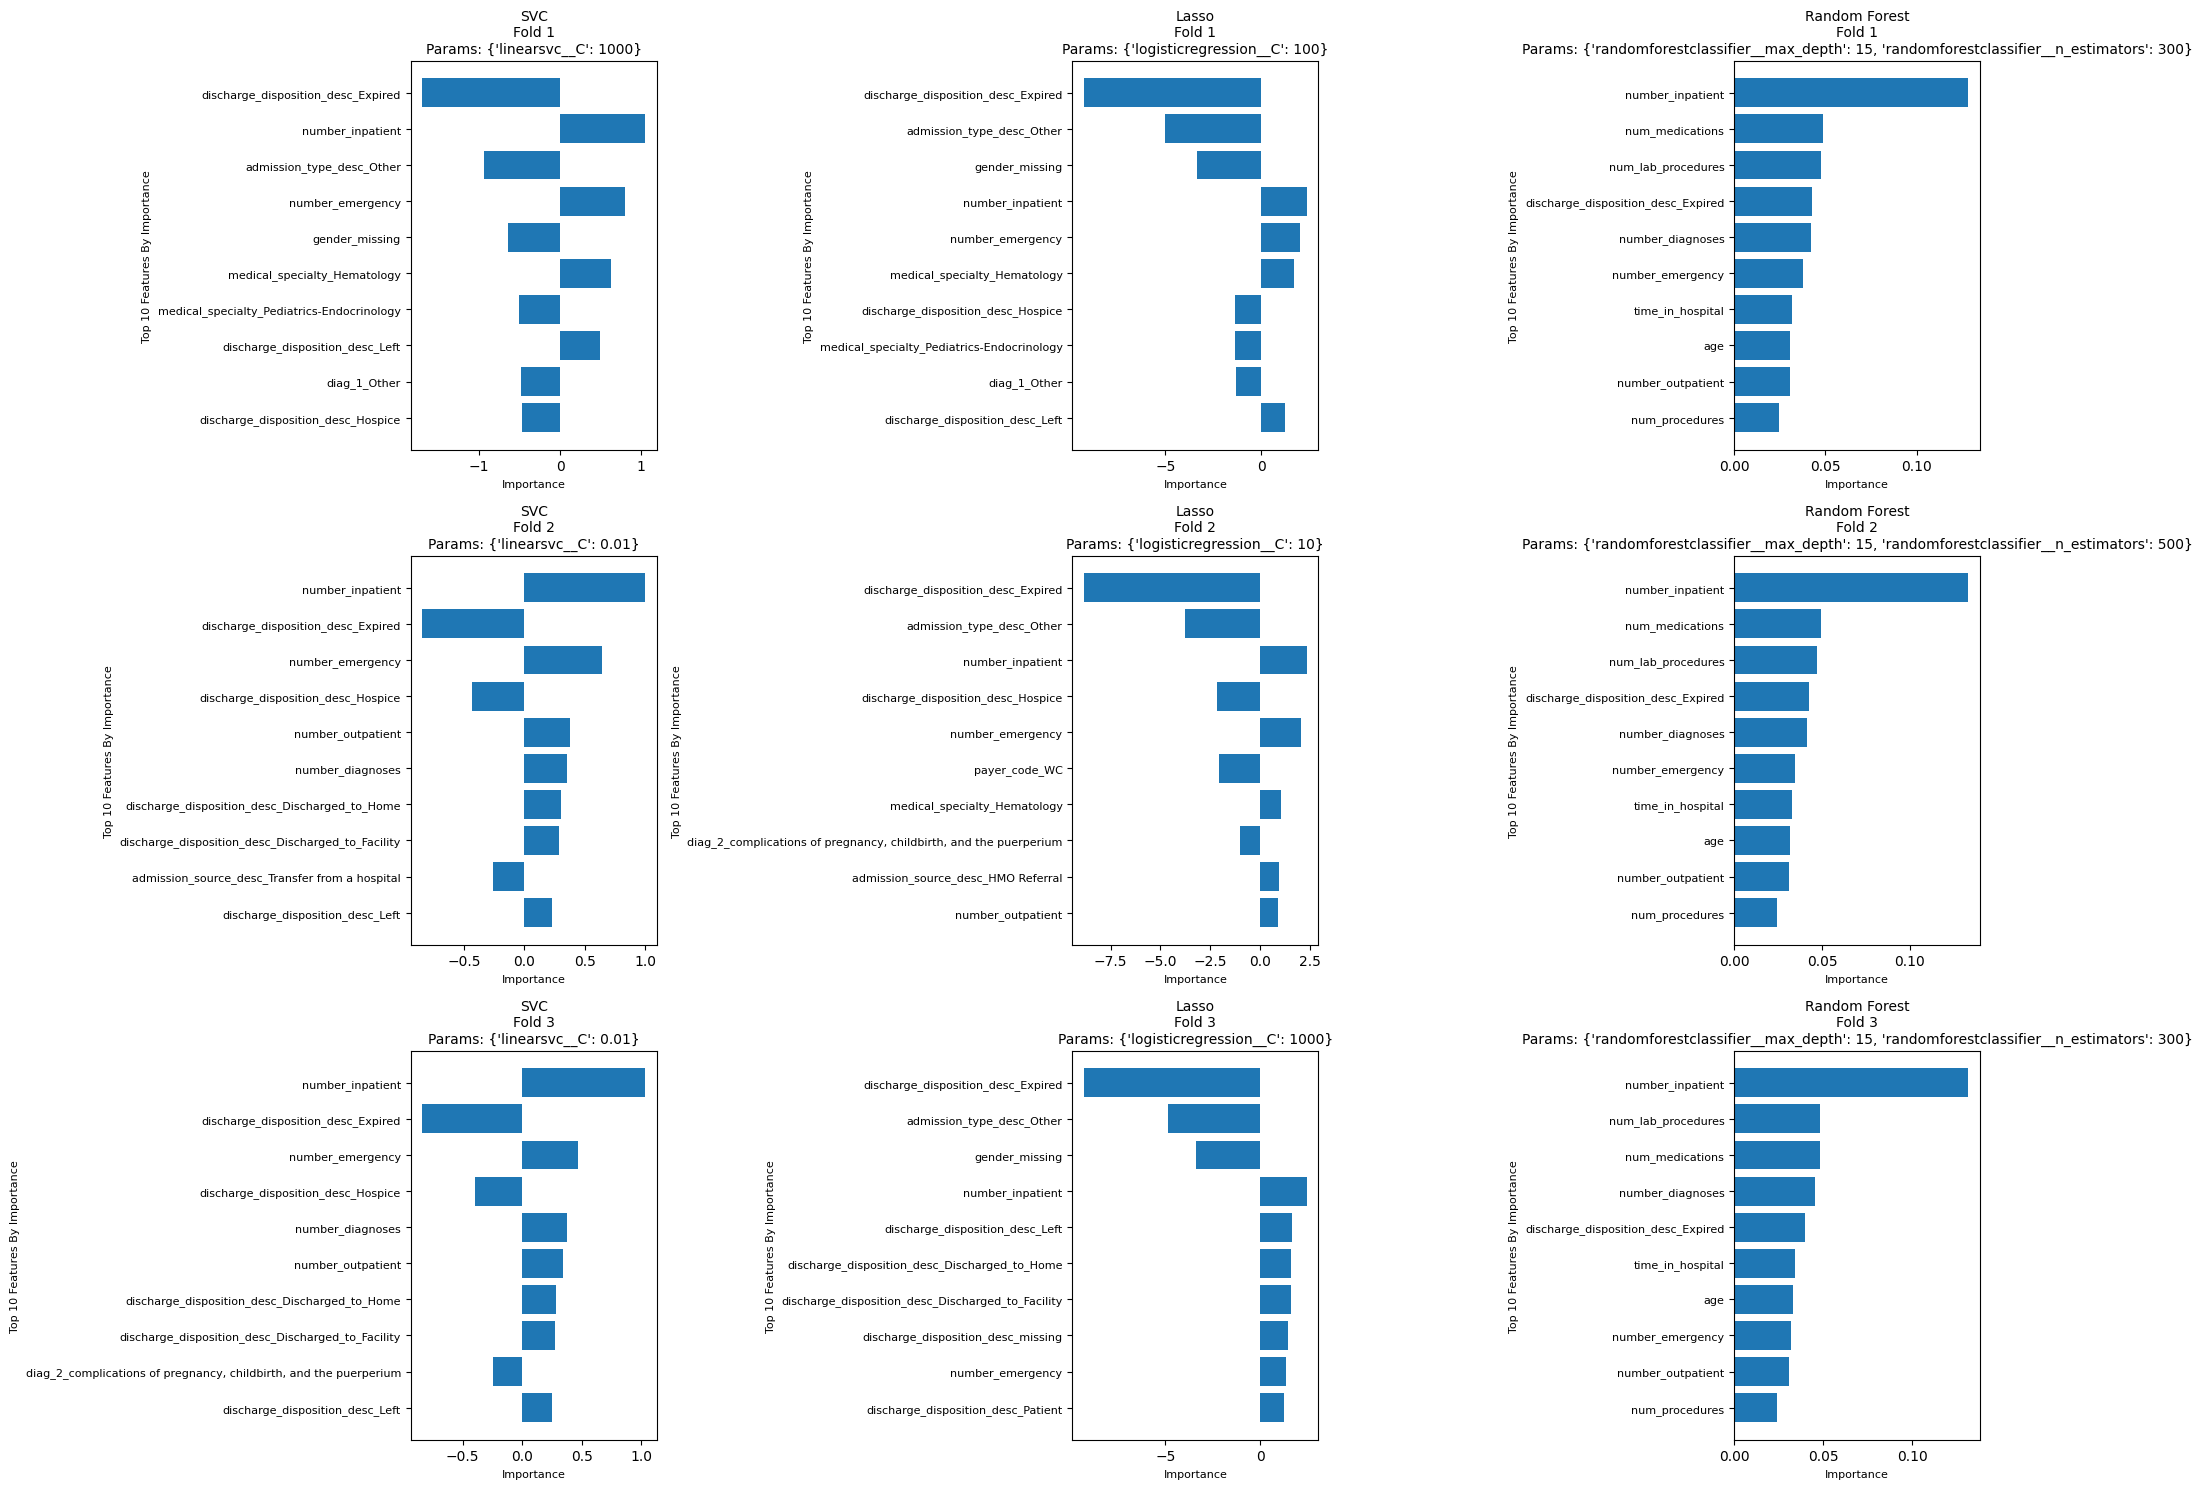

In [ ]:
# Block 38: Plot Top 10 Features

# Create subplot grid
fig, axes = plt.subplots(nrows=len(outer_folds), ncols=len(model_names), figsize=(20, 15))

# Loop over outer folds and models
for i, fold in enumerate(outer_folds):
    for j, model_name in enumerate(model_names):
        ax = axes[i, j]
        
        # Retrieve best model entry for this model and outer fold
        best_entries = [entry for entry in results[model_name]['best_models'] if entry['outer_fold'] == fold]
        
        best_entry = best_entries[0]
        best_model = best_entry['trained_model']
        params = best_entry['model_params']
        
        # Extract the preprocessor and the best model from the pipeline
        preprocessor = best_model.steps[0][1]
        estimator = best_model.steps[-1][1]
        
        # Get the feature names from the preprocessor
        feature_names = preprocessor.get_feature_names_out()
        
        # Initialize importances to None
        importances = None
        if hasattr(estimator, "coef_"):
            # For Linear Models
            coef = estimator.coef_
            if coef.ndim > 1:
                importances = coef[0]
            else:
                importances = coef
        elif hasattr(estimator, "feature_importances_"):
            # For Random Forest
            importances = estimator.feature_importances_
        
        # Get indices for the top 10 features by absolute importance
        sorted_idx = np.argsort(np.abs(importances))[::-1][:10]
        top_importances = importances[sorted_idx]
        top_features = np.array(feature_names)[sorted_idx]
        
        # Plot the top 10 feature importances
        ax.barh(range(len(top_features)), top_importances, align='center')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features, fontsize=8)
        ax.invert_yaxis()  # Invert y-axis so that the top feature is at the top.
        ax.set_xlabel("Importance", fontsize=8)
        ax.set_ylabel("Top 10 Features By Importance", fontsize=8)
        ax.set_title(f"{model_name}\nFold {fold}\nParams: {params}", fontsize=10)

plt.tight_layout()
plt.show()


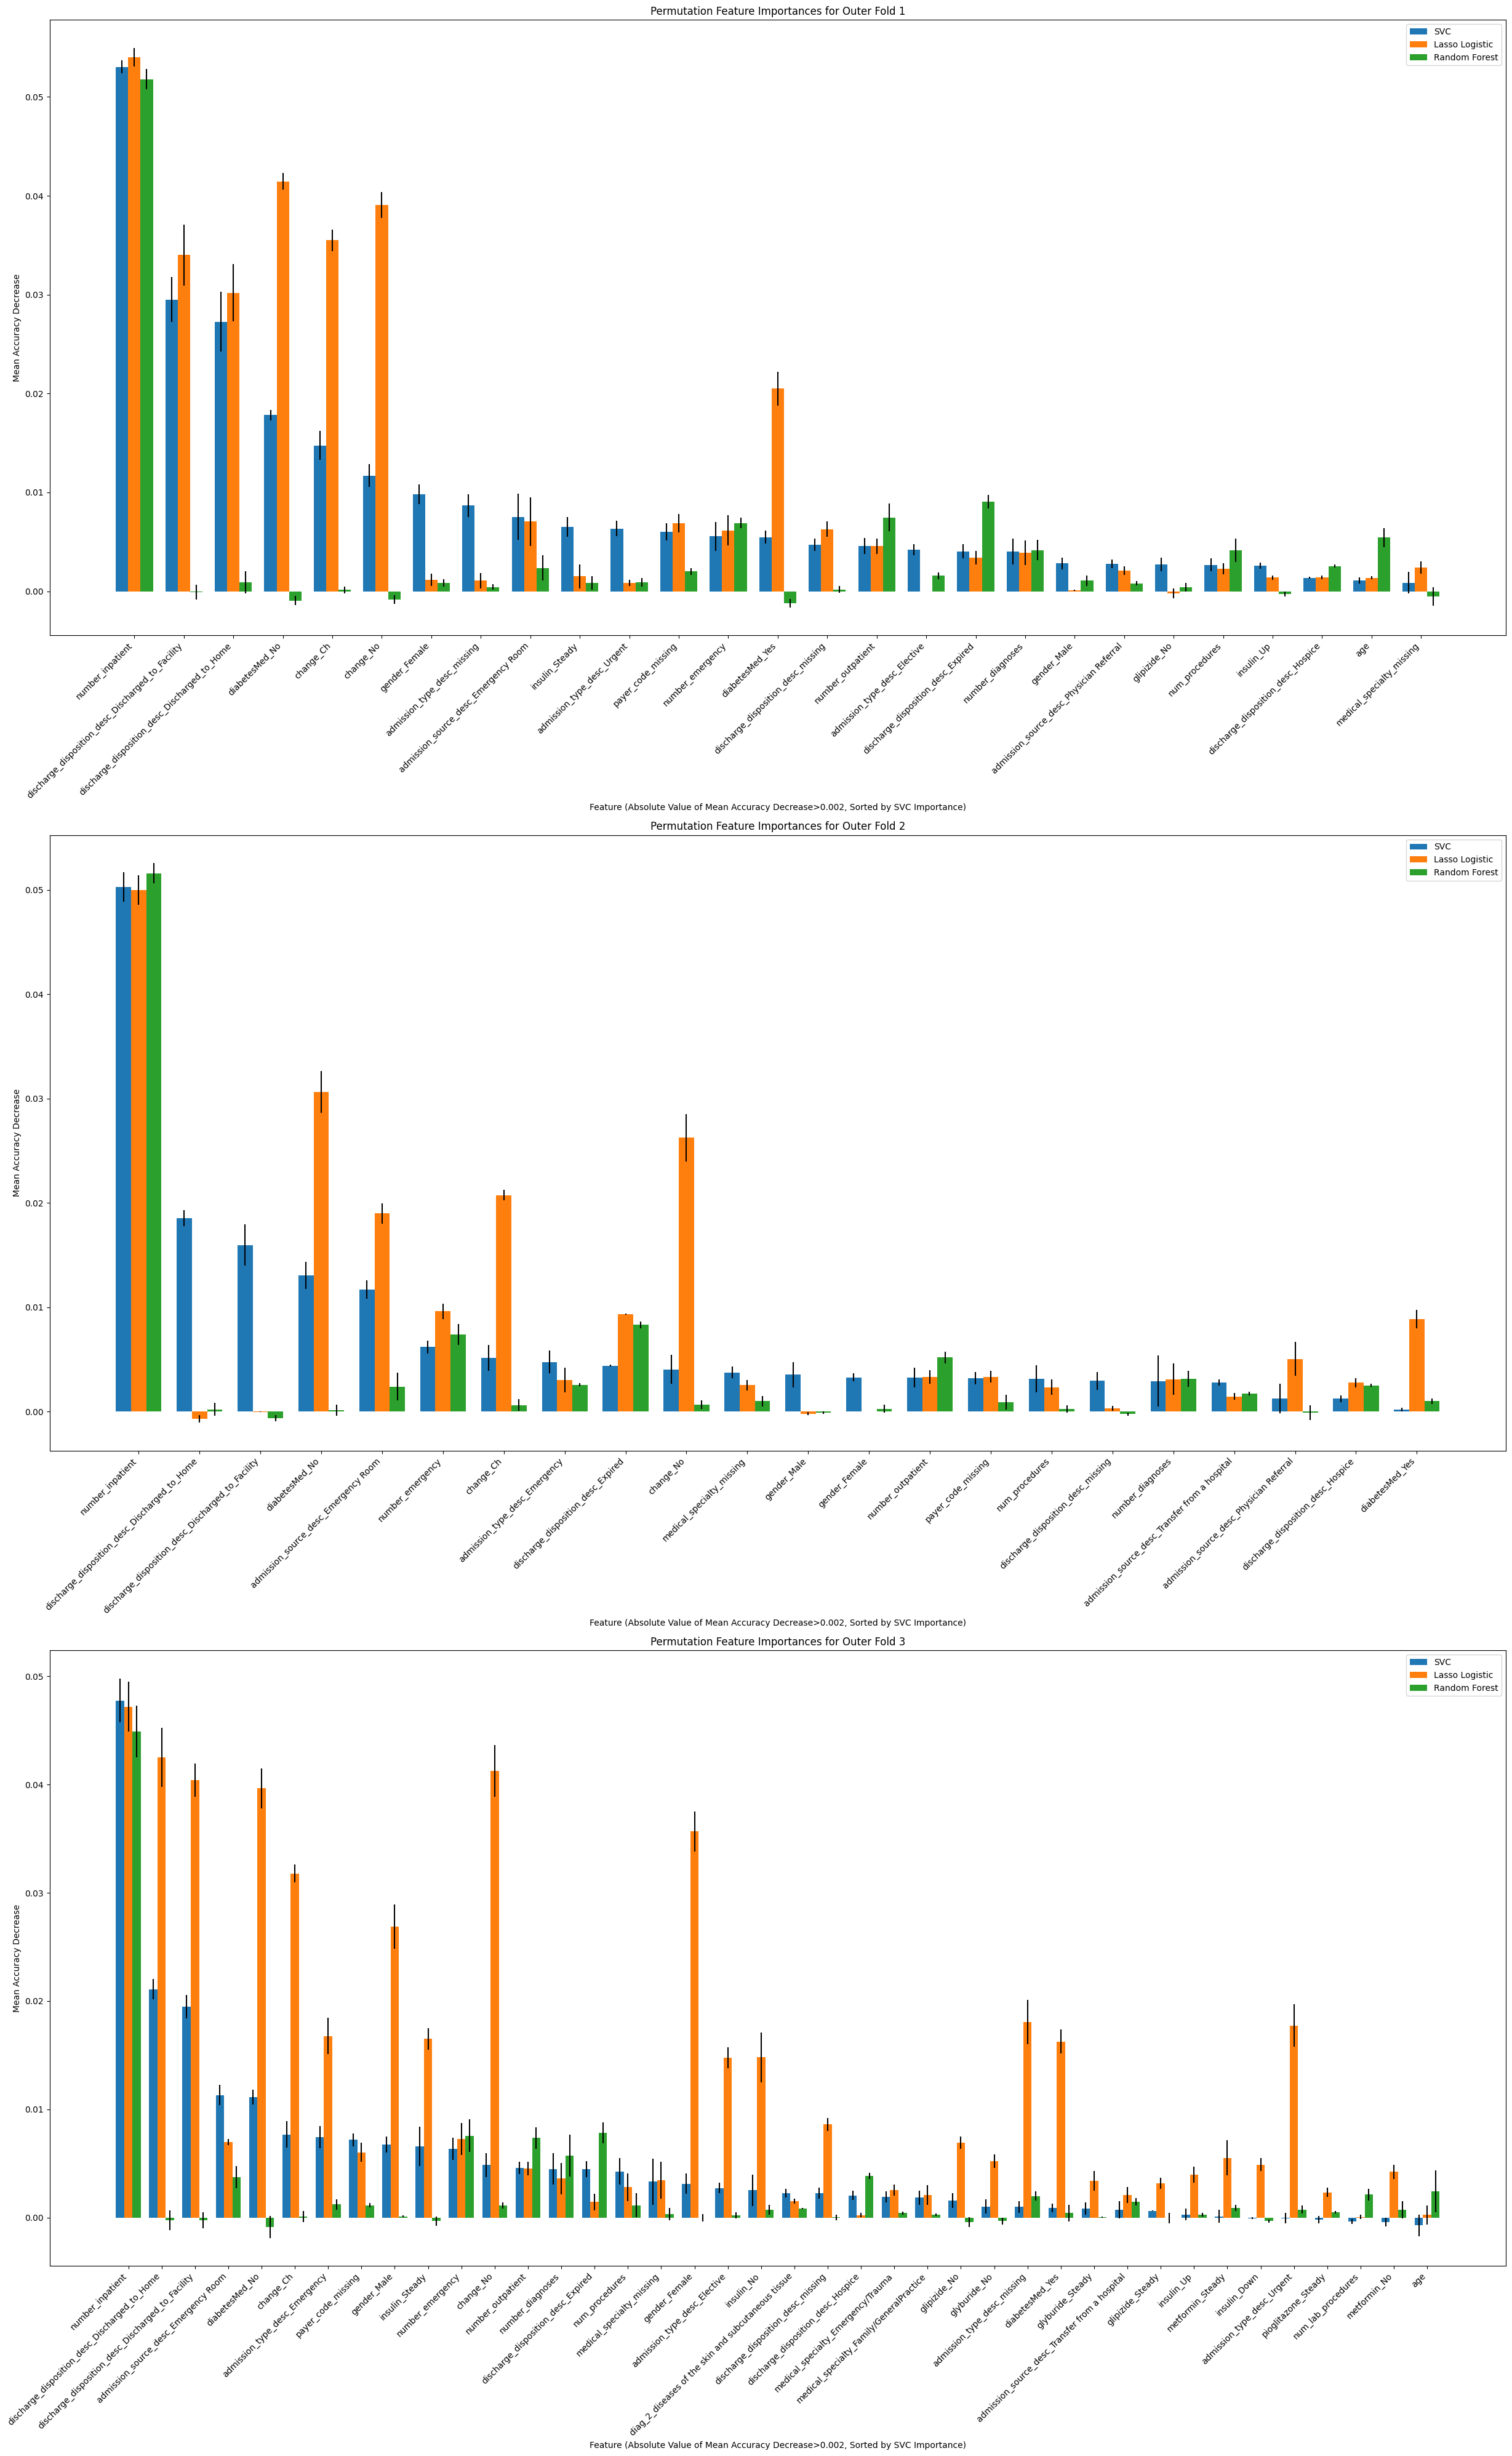

In [ ]:
# Block 39: Plot Permutation Importance

# Create a 3x1 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(25, 40))  

# Loop over each outer fold
for i, fold in enumerate(outer_folds):
    ax = axs[i]
    
    # Retrieve the best model for each algorithm from the current outer fold
    best_svc    = results['SVC']['best_models'][fold - 1]['trained_model']
    best_lasso  = results['Lasso']['best_models'][fold - 1]['trained_model']
    best_rf     = results['Random Forest']['best_models'][fold - 1]['trained_model']
    
    # Create the correct test set using the stored indices for the current fold
    test_idx = outer_fold_indices[fold]['test_idx']
    X_test_fold = X.iloc[test_idx]
    y_test_fold = y.iloc[test_idx]
    
    # Transform X_test using the preprocessor from best_svc
    X_test_transformed = best_svc.named_steps['columntransformer'].transform(X_test_fold)

    # Convert to dense array if necessary
    if hasattr(X_test_transformed, "toarray"):
        X_test_transformed = X_test_transformed.toarray()

    # Compute permutation importances for each model
    result_svc = permutation_importance(
        best_svc.named_steps['linearsvc'], X_test_transformed, y_test_fold,
        n_repeats=4, random_state=42, n_jobs=-1
    )
    result_lasso = permutation_importance(
        best_lasso.named_steps['logisticregression'], X_test_transformed, y_test_fold,
        n_repeats=4, random_state=42, n_jobs=-1
    )
    result_rf = permutation_importance(
        best_rf.named_steps['randomforestclassifier'], X_test_transformed, y_test_fold,
        n_repeats=4, random_state=42, n_jobs=-1
    )

    # Extract feature names from the ColumnTransformer for the baseline (SVC)
    try:
        feature_names = best_svc.named_steps['columntransformer'].get_feature_names_out()
    except (KeyError, AttributeError):
        num_features = X_test_transformed.shape[1]
        feature_names = np.array([f"Feature {i}" for i in range(num_features)])

    # Threshold to limit features added to plot
    threshold = 0.002 
    mask = ((abs(result_svc.importances_mean) > threshold) |
            (abs(result_lasso.importances_mean) > threshold) |
            (abs(result_rf.importances_mean) > threshold))
            
    # Select the features that pass the threshold
    selected_idx = np.where(mask)[0] 

    # Sort the selected features by SVC's importances in descending order
    sorted_idx = selected_idx[np.argsort(result_svc.importances_mean[selected_idx])[::-1]]
    
    # Filter the feature names and importance values for each model
    feature_names_filtered = feature_names[sorted_idx]
    svc_importances = result_svc.importances_mean[sorted_idx]
    svc_std = result_svc.importances_std[sorted_idx]

    lasso_importances = result_lasso.importances_mean[sorted_idx]
    lasso_std = result_lasso.importances_std[sorted_idx]

    rf_importances = result_rf.importances_mean[sorted_idx]
    rf_std = result_rf.importances_std[sorted_idx]

    num_features_filtered = len(feature_names_filtered)
    indices = np.arange(num_features_filtered)
    width = 0.25
    
    # Plot bars for each model 
    ax.bar(indices + 0.25, svc_importances, yerr=svc_std, width=width, label="SVC")
    ax.bar(indices + 0.50, lasso_importances, yerr=lasso_std, width=width, label="Lasso Logistic")
    ax.bar(indices + 0.75, rf_importances, yerr=rf_std, width=width, label="Random Forest")
    ax.set_xticks(indices + 0.50)
    ax.set_xticklabels(feature_names_filtered, rotation=45, ha="right")
    ax.legend()
    ax.set_ylabel("Mean Accuracy Decrease")
    ax.set_xlabel("Feature (Absolute Value of Mean Accuracy Decrease>0.002, Sorted by SVC Importance)")
    ax.set_title(f"Permutation Feature Importances for Outer Fold {fold}")

plt.tight_layout()
plt.show()


# Model Selection

In [ ]:
# Code Block 40: Model Definitions for Random Forest with Feature Selection

# Define hyperparameter grid for the Random Forest + feature selection pipeline
param_grid = {
    'selectkbest__k': [90, 110, 120, 130, 'all'],
    'randomforestclassifier__n_estimators': [100, 300, 500, 800, 1000],
    'randomforestclassifier__max_depth': [5, 10, 15, 20]
}

# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=24112897)

# Dictionary to store results
rf_results = {
    'outer_fold_cv_results': [],
    'best_models': [],
    'test_scores': [],
    'confusion_matrices': [],
    'roc_curves': []
}

In [ ]:
# Block 41: Random Forest Modeling Pipeline with Feature Selection

# Outer CV loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"Nested CV Outer Fold {outer_fold}")

    # Get numeric and categorical columns
    numeric_cols = X_train.select_dtypes(include='number').columns
    categorical_cols = X_train.select_dtypes(exclude='number').columns

    # Create numeric pipeline
    numeric_pipeline = Pipeline([("scaler", MinMaxScaler())])

    # Create categorical pipeline
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
        ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine both pipelines
    preprocessor = ColumnTransformer([
        ("numerical", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ], verbose_feature_names_out=False)

    # Construct pipeline with feature selection
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif)),\
        ("randomforestclassifier", RandomForestClassifier(random_state=24112897, class_weight='balanced'))
    ])

    # Set up inner CV with a different random state per outer fold
    inner_cv_random_state = 24112897 + outer_fold
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=inner_cv_random_state)

    # Grid search for hyperparameter tuning using inner CV 
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Store inner CV results for this outer fold
    rf_results['outer_fold_cv_results'].append({
        'outer_fold': outer_fold,
        'cv_results': pd.DataFrame(grid_search.cv_results_)
    })

    # Get the best model from this outer fold
    best_model = grid_search.best_estimator_
    rf_results['best_models'].append({
        'outer_fold': outer_fold,
        'model_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'trained_model': best_model
    })

    print(f"    Best params: {grid_search.best_params_}, CV Score: {grid_search.best_score_:.4f}")

    # Evaluate the best model on the outer test set
    y_pred = best_model.predict(X_test)
    metrics = {
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_test, y_pred)
    }
    rf_results['test_scores'].append({
        'outer_fold': outer_fold,
        'metrics': metrics
    })

    # Calculate confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    rf_results['confusion_matrices'].append({
        'outer_fold': outer_fold,
        'confusion_matrix': cm
    })

    # Calculate ROC curve and AUC score
    try:
        y_proba = best_model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = best_model.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    rf_results['roc_curves'].append({
        'outer_fold': outer_fold,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    })

    # Print test metrics for this fold
    print("    Test Scores:")
    for metric_name, score in metrics.items():
        print(f"      {metric_name}: {score:.4f}")
    print()


Nested CV Outer Fold 1
    Best params: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 800, 'selectkbest__k': 'all'}, CV Score: 0.6102
    Test Scores:
      f1: 0.6396
      accuracy: 0.6394

Nested CV Outer Fold 2
    Best params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 300, 'selectkbest__k': 'all'}, CV Score: 0.6121
    Test Scores:
      f1: 0.6319
      accuracy: 0.6313

Nested CV Outer Fold 3
    Best params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 1000, 'selectkbest__k': 'all'}, CV Score: 0.6110
    Test Scores:
      f1: 0.6351
      accuracy: 0.6347



In [314]:
# Block 42: Get Summary of Results

print("Summary of Results:")

# CV scores from inner CV 
cv_scores = [fold['cv_score'] for fold in rf_results['best_models']]

# Test scores for each metric from outer CV
test_metrics = {}
for metric in ['f1', 'accuracy']:
    metric_scores = [score_data['metrics'][metric] for score_data in rf_results['test_scores']]
    test_metrics[metric] = (np.mean(metric_scores), np.std(metric_scores))

print("Random Forest:")
print(f"  Average CV Score (f1): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print("  Test Scores (avg ± std):")
for metric, (mean, std) in test_metrics.items():
    print(f"    {metric}: {mean:.4f} ± {std:.4f}")
print()


Summary of Results:
Random Forest:
  Average CV Score (f1): 0.6111 ± 0.0007
  Test Scores (avg ± std):
    f1: 0.6355 ± 0.0032
    accuracy: 0.6351 ± 0.0033



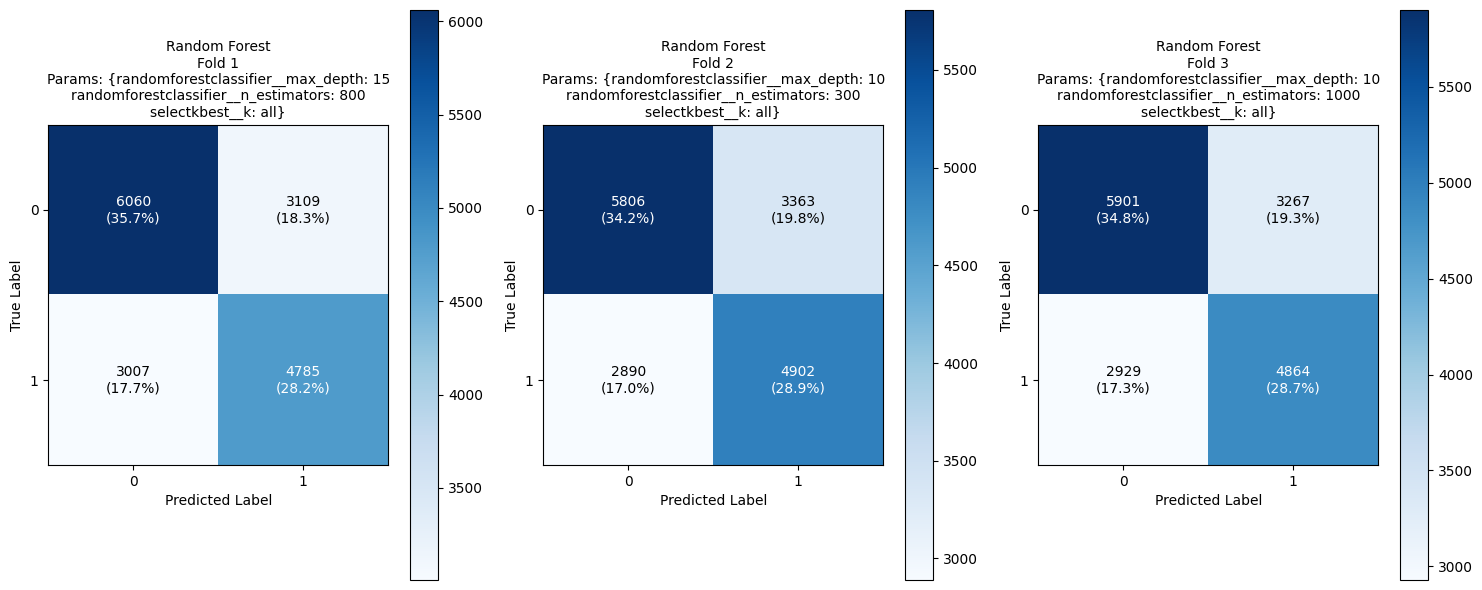

In [315]:
# Block 43: Plot confusion matrices

# Define outer_folds 
outer_folds = [1, 2, 3]

# Create subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Loop through folds 
for i, fold in enumerate(outer_folds):
    
    ax = axes[i]
    
    # Retrieve the confusion matrix for the current outer fold
    cm_entry = [entry for entry in rf_results['confusion_matrices'] if entry['outer_fold'] == fold]
    if cm_entry:
        cm = cm_entry[0]['confusion_matrix']
    else:
        cm = np.array([[0, 0], [0, 0]])
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Retrieve best model parameters for labeling
    best_entry = [entry for entry in rf_results['best_models'] if entry['outer_fold'] == fold]
    params = best_entry[0]['model_params'] if best_entry else {}

    # Split parameter string into two lines for better readability
    param_str = "{"+"\n".join([f"{key}: {value}" for key, value in params.items()])+ "}"

    # Set layout
    ax.set_title(f"Random Forest\nFold {fold}\nParams: {param_str}", fontsize=10)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    
    # Annotate cells with counts and percentages
    total = cm.sum()
    for k in range(cm.shape[0]):
        for l in range(cm.shape[1]):
            count = cm[k, l]
            percent = count / total * 100 if total > 0 else 0
            color = "white" if k == l else "black"
            ax.text(l, k, f"{count:d}\n({percent:.1f}%)", ha="center", va="center", color=color)

plt.tight_layout()
plt.show()


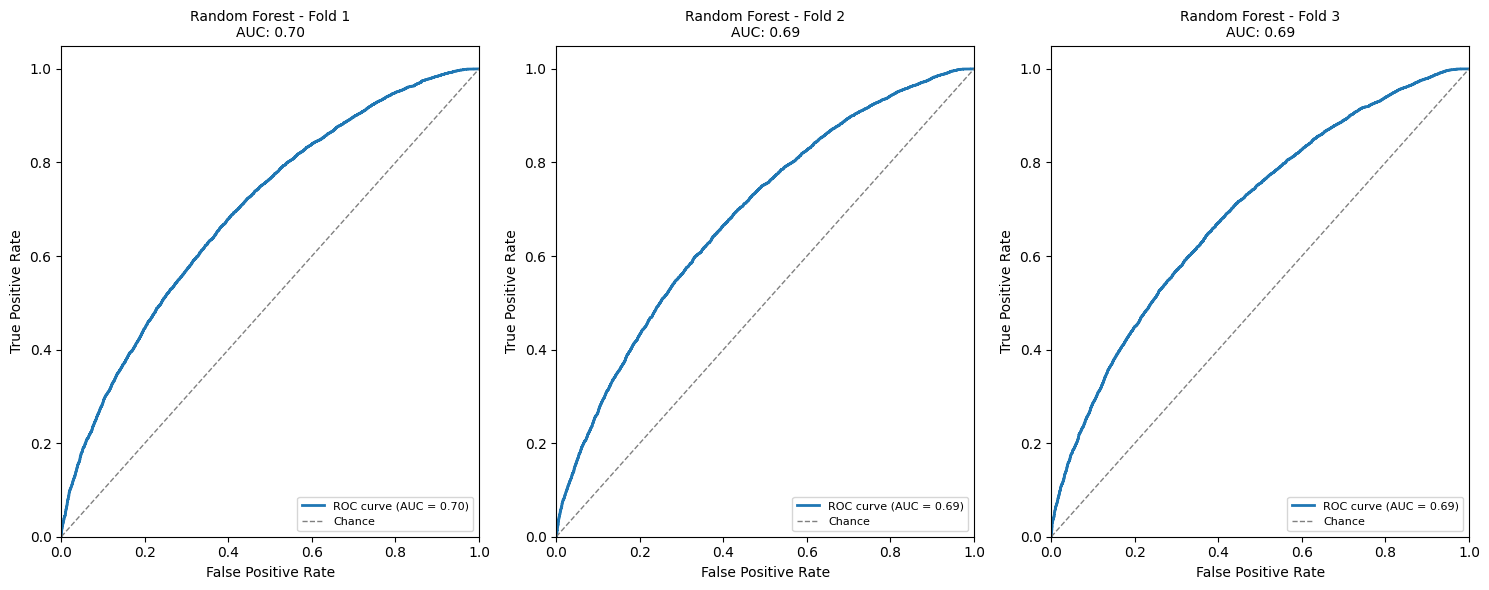

In [316]:
# Block 44: Plot ROC curves

# Create subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Loop through folds
for i, fold in enumerate(outer_folds):
    ax = axes[i]
    
    # Retrieve ROC curve data for this fold
    roc_entry = [entry for entry in rf_results['roc_curves'] if entry['outer_fold'] == fold]
    if roc_entry:
        roc_data = roc_entry[0]
        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        roc_auc = roc_data['auc']
    else:
        fpr, tpr, roc_auc = np.array([]), np.array([]), 0.0
    
    # Plot ROC curve
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right", fontsize=8)
    ax.set_title(f"Random Forest - Fold {fold}\nAUC: {roc_auc:.2f}", fontsize=10)

plt.tight_layout()
plt.show()

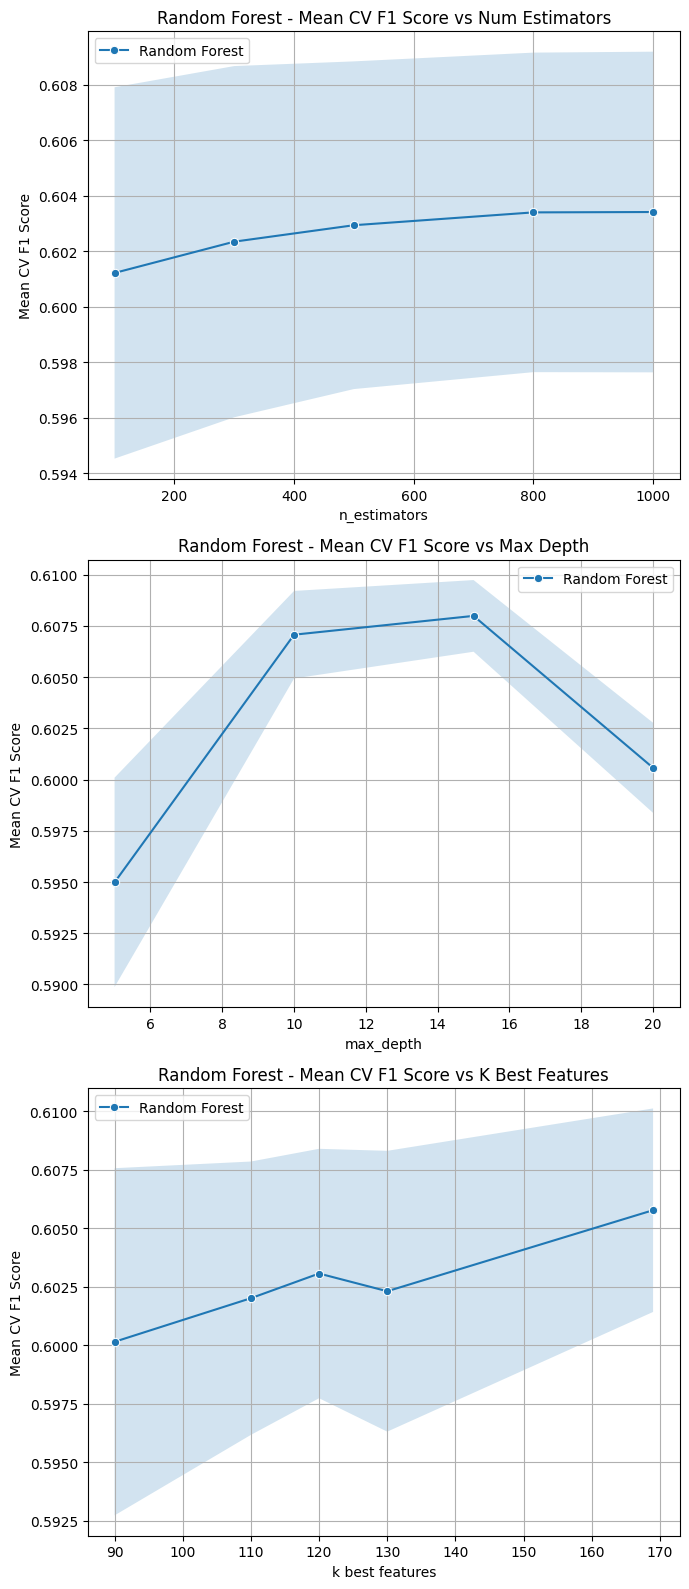

In [ ]:
# Block 45: Plot hyperparameter performance

# Collect inner CV results
all_cv_results = pd.concat(
    [fold['cv_results'] for fold in rf_results['outer_fold_cv_results']], 
    ignore_index=True
)

# Define hyperparameter configurations for plotting 
hp_configs = [
    (
        'param_randomforestclassifier__n_estimators',
        'Random Forest - Mean CV F1 Score vs Num Estimators',
        'n_estimators'
    ),
    (
        'param_randomforestclassifier__max_depth',
        'Random Forest - Mean CV F1 Score vs Max Depth',
        'max_depth'
    ),
    (
        'param_selectkbest__k',
        'Random Forest - Mean CV F1 Score vs K Best Features',
        'k best features'
    )
]

# Create subplot grid
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 16))

# Change "all" to the number of columns in the dataset
all_cv_results['param_selectkbest__k'] = all_cv_results['param_selectkbest__k'].replace('all', 169)

# Loop through each configuration and plot performance
for ax, (param_name, title, xlabel) in zip(axes, hp_configs):
    # Compute the mean CV score for each hyperparameter value
    param_stats = (
        all_cv_results.groupby(param_name)['mean_test_score']
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    
    # Plot lineplot with shaded area for standard deviation
    sns.lineplot(
        x=param_stats[param_name],
        y=param_stats['mean'],
        marker='o',
        label='Random Forest',
        ci=None,
        ax=ax
    )
    ax.fill_between(
        param_stats[param_name],
        param_stats['mean'] - param_stats['std'],
        param_stats['mean'] + param_stats['std'],
        alpha=0.2
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Mean CV F1 Score')
    ax.grid(True)

plt.tight_layout()
plt.show()



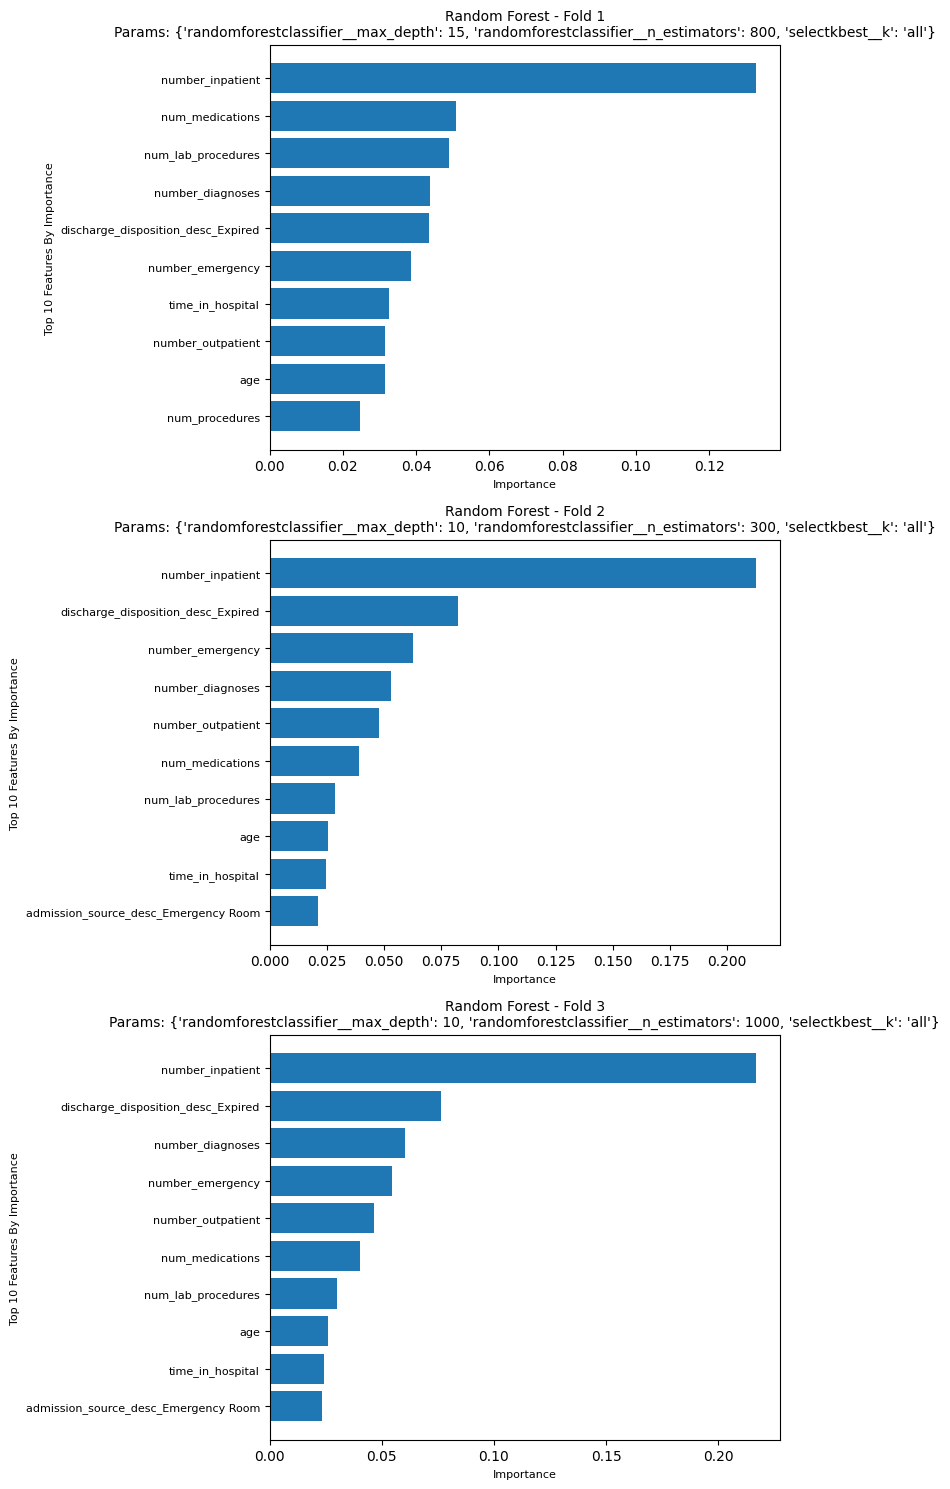

In [326]:
# Block 46: Plot top 10 features

# Create subplot grid
fig, axes = plt.subplots(nrows=len(outer_folds), ncols=1, figsize=(8, 15))

# Loop through outer folds 
for i, fold in enumerate(outer_folds):
    ax = axes[i]
    
    # Retrieve the best model for this outer fold
    best_entries = [entry for entry in rf_results['best_models'] if entry['outer_fold'] == fold]
    if not best_entries:
        ax.text(0.5, 0.5, "No model found", ha='center', va='center')
        continue
    
    # Get the best model and its parameters
    best_entry = best_entries[0]
    best_model = best_entry['trained_model']
    params = best_entry['model_params']
    
    # Extract the preprocessor and estimator from the pipeline
    preprocessor = best_model.steps[0][1]
    estimator = best_model.steps[-1][1]
    
    # Get the full feature names from the preprocessor 
    feature_names = preprocessor.get_feature_names_out()

    # Get the feature selector from the pipeline
    feature_selector = best_model.steps[1][1]
    mask = feature_selector.get_support()
    feature_names = np.array(feature_names)[mask]
    
    # Determine importances 
    importances = estimator.feature_importances_

    # Select the top 10 features by absolute importance
    sorted_idx = np.argsort(np.abs(importances))[::-1][:10]
    top_importances = importances[sorted_idx]
    top_features = np.array(feature_names)[sorted_idx]
    
    # Plot horizontal bar chart 
    ax.barh(range(len(top_features)), top_importances, align='center')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features, fontsize=8)
    ax.invert_yaxis()  # highest importance on top
    ax.set_xlabel("Importance", fontsize=8)
    ax.set_ylabel("Top 10 Features By Importance", fontsize=8)
    ax.set_title(f"Random Forest - Fold {fold}\nParams: {params}", fontsize=10)

plt.tight_layout()
plt.show()
